# Predikcija stope nasilnog kriminala

Cilj projekta je izgradnja i poređenje modela za predikciju stope nasilnog kriminala u 
lokalnim zajednicama na osnovu dostupnih socio-ekonomskih i demografskih 
karakteristika. Podaci sadrže velik broj ulaznih promenljivih koje opisuju populaciju, 
obrazovanje,  zaposlenost,  strukturu  domaćinstava,  prihode,  stanovanje  i  policijske 
resurse, dok su izlazne varijable povezane sa kriminalitetom. 

**Ciljevi projekta** su:
* izgradnja i evaluacija modela za predikciju ciljne varijable na tabelarnim podacima sa velikim brojem obeležja i nedostajućim vrednostima, 
* poređenje naprednih regresionih algoritama  nad  istim  protokolom  obrade podataka, 
* robustnost modela na autlajere i šum, 
* analiza značaja obeležja i interpretabilnost radi identifikacije  faktora koji najviše doprinose predikciji.

## 0) Setup

In [40]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

REPO = Path(".").resolve()
DATA_PATH = REPO / "data" / "CommViolPredUnnormalizedData.txt"
CSV_DIR = REPO / "results" / "csv"
PLOT_DIR = REPO / "results" / "plots"

print("DATA:", DATA_PATH.exists(), DATA_PATH)
print("CSV :", CSV_DIR.exists(), CSV_DIR)
print("PLOT:", PLOT_DIR.exists(), PLOT_DIR)

DATA: True C:\Users\korisnik\Desktop\FAKULTET\2. GODINA\NUMERICKI SOFTVER\PROJEKAT\implementacija\PROJEKAT_NANS\data\CommViolPredUnnormalizedData.txt
CSV : True C:\Users\korisnik\Desktop\FAKULTET\2. GODINA\NUMERICKI SOFTVER\PROJEKAT\implementacija\PROJEKAT_NANS\results\csv
PLOT: True C:\Users\korisnik\Desktop\FAKULTET\2. GODINA\NUMERICKI SOFTVER\PROJEKAT\implementacija\PROJEKAT_NANS\results\plots


## 1) Skup podataka

Skup podataka koji se analizira i nad kojim će se primenjivati regresioni modeli je **Communities and Crime (Unnormalized)** skup podataka sa UCI Machine Learning Repository.
Skup podataka sadrži podatke o 2215  redova  (lokalne  zajednice)  i  obuhvata  147 kolona (atributa).
Kolona čiju vrednost želimo da predvidimo je **violentPerPop**,  koja  predstavlja stopu nasilnog kriminala po glavi stanovnika.

In [41]:
from src.data.make_dataset import load_dataset, prepare_dataframe, TARGET, ID_COLS, LEAKAGE_COLS

df_raw = load_dataset(DATA_PATH)
print("RAW shape:", df_raw.shape)

df = prepare_dataframe(df_raw)
print("Prepared shape:", df.shape)
print("TARGET:", TARGET)

print("ID_COLS:", ID_COLS)
print("LEAKAGE_COLS:", len(LEAKAGE_COLS))
df.head()

RAW shape: (2215, 147)
Prepared shape: (1994, 126)
TARGET: violentPerPop
ID_COLS: ['communityname', 'countyCode', 'communityCode', 'fold']
LEAKAGE_COLS: 17


State     pop  perHoush  pctBlack  pctWhite  pctAsian  pctHisp  pct12-21  \
0    NJ   11980      3.10      1.37     91.78      6.50     1.88     12.47   
1    PA   23123      2.82      0.80     95.57      3.44     0.85     11.01   
2    OR   29344      2.43      0.74     94.33      3.43     2.35     11.36   
3    NY   16656      2.40      1.70     97.35      0.50     0.70     12.55   
5    MO  140494      2.45      2.51     95.65      0.90     0.95     18.09   

   pct12-29  pct16-24  ...  landArea  popDensity  pctUsePubTrans  \
0     21.44     10.93  ...       6.5      1845.9            9.63   
1     21.30     10.48  ...      10.6      2186.7            3.84   
2     25.88     11.01  ...      10.6      2780.9            4.37   
3     25.20     12.19  ...       5.2      3217.7            3.31   
5     32.89     20.04  ...      70.4      1995.7            0.97   

   policCarsAvail  policOperBudget  pctPolicPatrol  gangUnit  \
0             NaN              NaN             NaN       NaN   
1             NaN              NaN             NaN       NaN   
2             NaN              NaN             NaN       NaN   
3             NaN              NaN             NaN       NaN   
5             NaN              NaN             NaN       NaN   

   pctOfficDrugUnit  policBudgetPerPop  violentPerPop  
0               0.0                NaN          41.02  
1               0.0                NaN         127.56  
2               0.0                NaN         218.59  
3               0.0                NaN         306.64  
5               0.0                NaN         442.95  

[5 rows x 126 columns]

- Raw skup: 2215 redova i 147 kolona.
- Nakon uklanjanja ID kolona (4) i leakage kolona (17), dobijamo 147 − 21 = 126 atributa.
- Nakon izbacivanja redova gde nedostaje target (`violentPerPop`), ostaje 1994 redova (uklonjeno 221 red).

## 2) Pretprocesiranje

Prvi korak u realizaciji projekta predstavlja pretprocesiranje podataka iz skupa 
Communities and Crime (unnormalized). Skup podataka sadrži nedostajuće vrednosti koje 
su označene simbolom `?`, kao i atribute sa različitim skalama i značajnim rasponom 
vrednosti.

U okviru pretprocesiranja biće sprovedeni sledeći koraci: 
- zamena simboličkih oznaka nedostajućih vrednosti `?` odgovarajućim numeričkim oznakama
- izbacivanje atributa sa velikim procentom nedostajućih vrednosti (>80% missing)
- imputacija preostalih nedostajućih vrednosti
- kodiranje kategorijske promenljive `state` (one-hot za linearne modele; za CatBoost ostaje kategorijska)
- uklanjanje  potencijalnih leakage atributa vezanih za kriminal (sve “crime” kolone osim ciljne)
- skaliranje obeležja tamo gde je potrebno (StandardScaler / RobustScaler - linearni modeli i regularizacija)

Interpolacija se ne koristi, budući da redovi u skupu podataka ne poseduju prirodan redosled, te interpolirane vrednosti ne bi imale statističko niti semantičko značenje. Radi se median imputacija kao baseline, uz poređenje sa KNN/MICE imputacijom.

* `Median`: Za svaku kolonu koja ima nedostajuće vrednosti, svih postojećih podataka i njome se popune praznine.
* `KNN`: Traži najsličnijih *k* redova (suseda) onom redu u kojem podatak nedostaje. Gleda vrednosti u drugim kolonama da bi odredio ko je "sličan". Zatim uzima prosek ili medijanu vrednosti tih *k* suseda da popuni rupu.
* `MICE`: Posmatra svaku kolonu sa nedostajućim podacima kao "metu", a ostale kolone kao "prediktore". On bukvalno trenira seriju regresionih modela da predvidi svaku nedostajuću vrednost. Proces se ponavlja više puta (u krug) dok se vrednosti ne stabilizuju.

In [42]:
missing_ratio = df_raw.isna().mean().sort_values(ascending=False)
thr = 0.80
cols_over_thr = missing_ratio[missing_ratio > thr]
print("Broj kolona sa missing >", thr, "=", len(cols_over_thr))
cols_over_thr.to_frame("missing_ratio").head(30)

Broj kolona sa missing > 0.8 = 22


missing_ratio
pctPolicBlack           0.845147
policCallPerOffic       0.845147
policePerPop2           0.845147
policCarsAvail          0.845147
policOperBudget         0.845147
pctPolicPatrol          0.845147
policAveOT              0.845147
gangUnit                0.845147
policBudgetPerPop       0.845147
pctPolicWhite           0.845147
racialMatch             0.845147
numPolice               0.845147
policePerPop            0.845147
policeField             0.845147
policeFieldPerPop       0.845147
numDiffDrugsSeiz        0.845147
officDrugUnits          0.845147
pctPolicMinority        0.845147
pctPolicAsian           0.845147
policCallPerPop         0.845147
policeCalls             0.845147
pctPolicHisp            0.845147

In [43]:
from src.data.preprocess import DropHighMissing

dropper = DropHighMissing(threshold=0.80, target=TARGET)
dropper.fit(df_raw)
drop_list = dropper.to_drop_

print("DropHighMissing (threshold=0.80) izbacuje", len(drop_list), "kolone.")
drop_list[:30]
pd.DataFrame({"dropped_col": drop_list}).head(30)

DropHighMissing (threshold=0.80) izbacuje 22 kolone.


dropped_col
0           numPolice
1        policePerPop
2         policeField
3   policeFieldPerPop
4         policeCalls
5     policCallPerPop
6   policCallPerOffic
7       policePerPop2
8         racialMatch
9       pctPolicWhite
10      pctPolicBlack
11       pctPolicHisp
12      pctPolicAsian
13   pctPolicMinority
14     officDrugUnits
15   numDiffDrugsSeiz
16         policAveOT
17     policCarsAvail
18    policOperBudget
19     pctPolicPatrol
20           gangUnit
21  policBudgetPerPop

* Kolone sa >80% missing su uglavnom policijski/patrol atributi…
* One se uklanjaju jer imputacija na tako velikom procentu missing-a može da uvede šum

In [44]:
from src.data.preprocess import build_preprocessor_linear, build_preprocessor_catboost

pre_lin = build_preprocessor_linear(df, imputer="median", scaler="standard", missing_threshold=0.80)
pre_cb  = build_preprocessor_catboost(df, imputer="median", missing_threshold=0.80)

pre_lin

Pipeline(steps=[('drop_target',
                 FunctionTransformer(func=<function build_preprocessor_linear.<locals>.<lambda> at 0x0000018DB2E82840>)),
                ('drop_high_missing', DropHighMissing(target='violentPerPop')),
                ('ct',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <function build_preprocessor_linear.<locals>.<lambda> at 0x0000018DB2E82520>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <function build_preprocessor_linear.<locals>.<lambda> at 0x0000018DB2E828E0>)]))])

In [45]:
pre_cb

Pipeline(steps=[('drop_target',
                 FunctionTransformer(func=<function build_preprocessor_catboost.<locals>.<lambda> at 0x0000018DB2E81BC0>)),
                ('drop_high_missing', DropHighMissing(target='violentPerPop')),
                ('df_imputer', CatBoostDfImputer())])

**Preprocessor za linearne modele (`pre_lin`)** je definisan kao scikit-learn Pipeline:
- prvo izbacuje target kolonu (`violentPerPop`) iz ulaza (sprečavanje leakage),
- zatim izbacuje kolone sa >80% missing,
- potom kroz `ColumnTransformer` odvaja numeričke i kategorijske kolone:
  - numeričke: imputacija (median/KNN/MICE) + skaliranje (Standard/Robust),
  - kategorijske (npr. `State`): imputacija najčešćom vrednošću + One-Hot encoding.

**Preprocessor za CatBoost (`pre_cb`)** zadržava kategorijske feature-e u izvornom obliku i radi imputaciju
u DataFrame formatu, što je pogodno za CatBoost.


Podaci se dele na:
- 60% trening (train)
- 20% validacija (val)
- 20% test

Hiperparametri se biraju k-fold cross-validation-om samo na trening skupu,
dok se test koristi isključivo za finalnu procenu generalizacije.

In [46]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1196, 125) Val: (399, 125) Test: (399, 125)


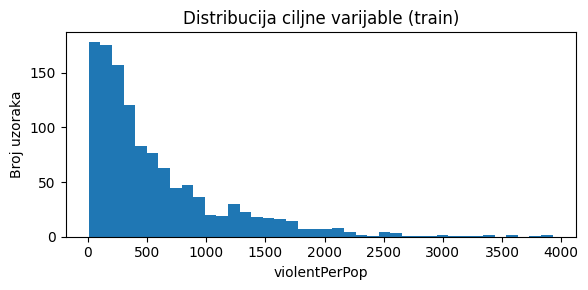

In [47]:
plt.figure(figsize=(6,3))
plt.hist(y_train, bins=40)
plt.title("Distribucija ciljne varijable (train)")
plt.xlabel("violentPerPop")
plt.ylabel("Broj uzoraka")
plt.tight_layout()
plt.show()

Grafik prikazuje raspodelu ciljne promenljive `violentPerPop` na trening skupu.

`violentPerPop` predstavlja **stopu nasilnog kriminala po populaciji** (broj nasilnih krivičnih dela na **100.000 stanovnika**), pa veće vrednosti znače veći intenzitet kriminala u posmatranoj zajednici.

Primećuje se **jaka asimetrija udesno** (long tail): većina opština ima relativno niske vrednosti, dok manji broj ima veoma visoke vrednosti (outlieri). Ovakva raspodela implicira da su ekstremni slučajevi teži za predikciju i da modeli često imaju veću grešku pri visokim vrednostima cilja.

## 3) Linearni modeli

### Bazni regresioni model (OLS)
OLS je referentni (baseline) model. Testiramo dve varijante:
- bez skaliranja
- sa standardizacijom (z-score)

Pored metrika (RMSE/MAE/R²), analiziramo i numeričku stabilnost dizajn matrice:
- rank (da li je matrica punog ranga)
- najmanju singularnu vrednost
- condition number (velike vrednosti ukazuju na multikolinearnost i nestabilne koeficijente)

In [48]:
df_ols = pd.read_csv(CSV_DIR / "ols_diagnostics.csv")
df_ols

variant  rank         s_min          cond  n_features
0      OLS_median_none   144  3.594320e-12  3.351541e+18         146
1  OLS_median_standard   144  9.341005e-15  1.817914e+16         146

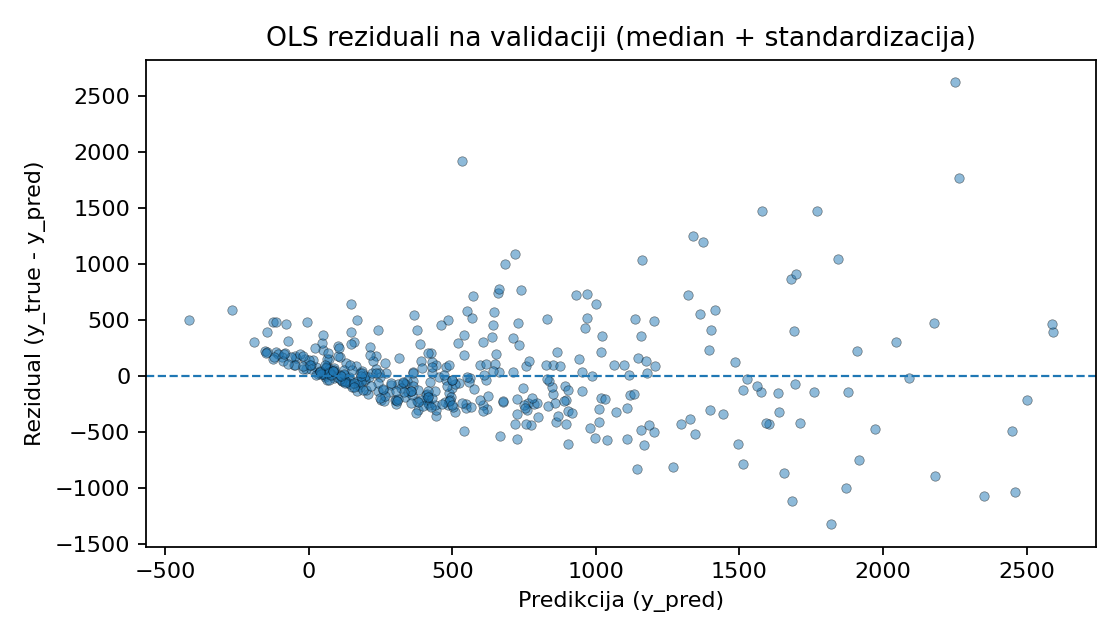

In [49]:
Image.open(PLOT_DIR / "ols_residuals_val.png")

**Tumačenje:** ako je `rank < n_features` i condition number ekstremno velik (npr. 10^16–10^18),
OLS rešenje je numerički nestabilno zbog multikolinearnosti. Takođe sa grafika reziduala možemo videti da pada equal variance pretpostavka i time možemo zaključiti da OLS nije pogodan za naš problem. To su glavni motivi za Ridge/Lasso/ElasticNet.

### Regularizovani linearni modeli (Ridge / Lasso / ElasticNet)

Kod OLS smo videli numeričku nestabilnost zbog multikolinearnosti (rank < broj feature-a i veliki condition number).
Zato uvodimo regularizaciju:

- **Ridge (L2):** dodaje kaznu $\lambda \sum_{i=1}^{n} \beta_i^2$ → stabilizuje koeficijente.
- **Lasso (L1):** dodaje kaznu $\lambda \sum_{i=1}^{n} |\beta_i|$ → može da postavi neke koeficijente na 0 (selekcija feature-a).
- **ElasticNet (L1 + L2):** kombinacija Ridge i Lasso → korisno kada postoje grupe korelisanih obeležja.

Hiperparametri se biraju pomoću **GridSearchCV u k-fold cross-validation** na trening skupu.

In [50]:
df_lin = pd.read_csv(CSV_DIR / "results_linear_baselines.csv")
cols = ["name","imputer","scaler","is_tuned","cv_rmse","val_rmse","val_r2","test_rmse","test_r2"]
top = df_lin.sort_values(["val_rmse","test_rmse"]).reset_index(drop=True)[cols].copy()

top["cv_rmse"] = top["cv_rmse"].round(3)
top["val_rmse"] = top["val_rmse"].round(3)
top["test_rmse"] = top["test_rmse"].round(3)
top["val_r2"] = top["val_r2"].round(4)
top["test_r2"] = top["test_r2"].round(4)

display(top.head(10))

name imputer    scaler  is_tuned  cv_rmse  val_rmse  \
0  ElasticNet(a=0.01,l1=0.5)    mice  standard     False  370.541   398.378   
1  ElasticNet(a=0.01,l1=0.5)  median  standard     False  370.527   398.390   
2  ElasticNet(a=0.01,l1=0.5)     knn  standard     False  370.497   398.411   
3             Ridge(alpha=1)    mice  standard     False  366.435   400.529   
4             Ridge(alpha=1)  median  standard     False  366.417   400.543   
5             Ridge(alpha=1)     knn  standard     False  366.378   400.566   
6  ElasticNet(a=0.01,l1=0.5)    mice    robust     False  370.415   401.029   
7  ElasticNet(a=0.01,l1=0.5)  median    robust     False  370.400   401.042   
8  ElasticNet(a=0.01,l1=0.5)     knn    robust     False  370.370   401.065   
9             Ridge(alpha=1)    mice    robust     False  367.044   401.642   

   val_r2  test_rmse  test_r2  
0  0.6573    354.500   0.6389  
1  0.6573    354.534   0.6388  
2  0.6572    354.586   0.6387  
3  0.6536    360.570   0.6264  
4  0.6535    360.599   0.6264  
5  0.6535    360.643   0.6263  
6  0.6527    361.763   0.6239  
7  0.6527    361.797   0.6239  
8  0.6526    361.848   0.6238  
9  0.6516    362.865   0.6217

Ova tabela prikazuje **TOP 10 kombinacija** (model + preprocesiranje) iz eksperimenta sa linearnim modelima,
sortiranih po **najmanjem `val_rmse`** (a zatim `test_rmse`).

Kolone znače:
- **name** – naziv modela (OLS, Ridge, Lasso, ElasticNet; “tuned” znači da su hiperparametri birani GridSearchCV-om)
- **imputer** – metoda imputacije missing vrednosti (median / KNN / MICE)
- **scaler** – skaliranje numeričkih atributa (none / standard / robust)
- **is_tuned** – da li je model podešavan (tuning) ili fiksna konfiguracija
- **cv_rmse** – prosečan RMSE na k-fold cross-validation na trening skupu
- **val_rmse / val_r2** – performanse na validacionom skupu (koristimo za izbor najboljeg modela)
- **test_rmse / test_r2** – performanse na test skupu (finalna procena generalizacije)

Ovo nam omogućava da uporedimo uticaj imputacije i skaliranja, kao i razliku između baznih i regularizovanih modela.

In [51]:
df_tuned = df_lin[df_lin["is_tuned"].astype(str).str.lower() == "true"].copy()
df_tuned = df_tuned.sort_values(["cv_rmse", "val_rmse", "test_rmse"]).reset_index(drop=True)

df_tuned_view = df_tuned.copy()
df_tuned_view["best_params"] = (
    df_tuned_view["best_params"].astype(str)
    .str.replace("np.float64", "", regex=False)
)

df_tuned_view[["name","imputer","scaler","cv_rmse","val_rmse","val_r2","test_rmse","test_r2","best_params"]]

name imputer    scaler     cv_rmse    val_rmse    val_r2  \
0       Lasso (tuned)    mice  standard  364.293361  402.136089  0.650784   
1  ElasticNet (tuned)    mice  standard  364.355449  402.817878  0.649599   
2       Ridge (tuned)    mice  standard  364.396356  403.309163  0.648743   

    test_rmse   test_r2                                        best_params  
0  364.241344  0.618778             {'model__alpha': (0.0610540229658533)}  
1  366.151529  0.614769  {'model__alpha': (0.001), 'model__l1_ratio': 0.9}  
2  367.256137  0.612441             {'model__alpha': (0.0517947467923121)}

Prikazani su najbolji hiperparametri dobijeni GridSearchCV-om (k-fold CV na trening skupu) za Ridge, Lasso i ElasticNet.

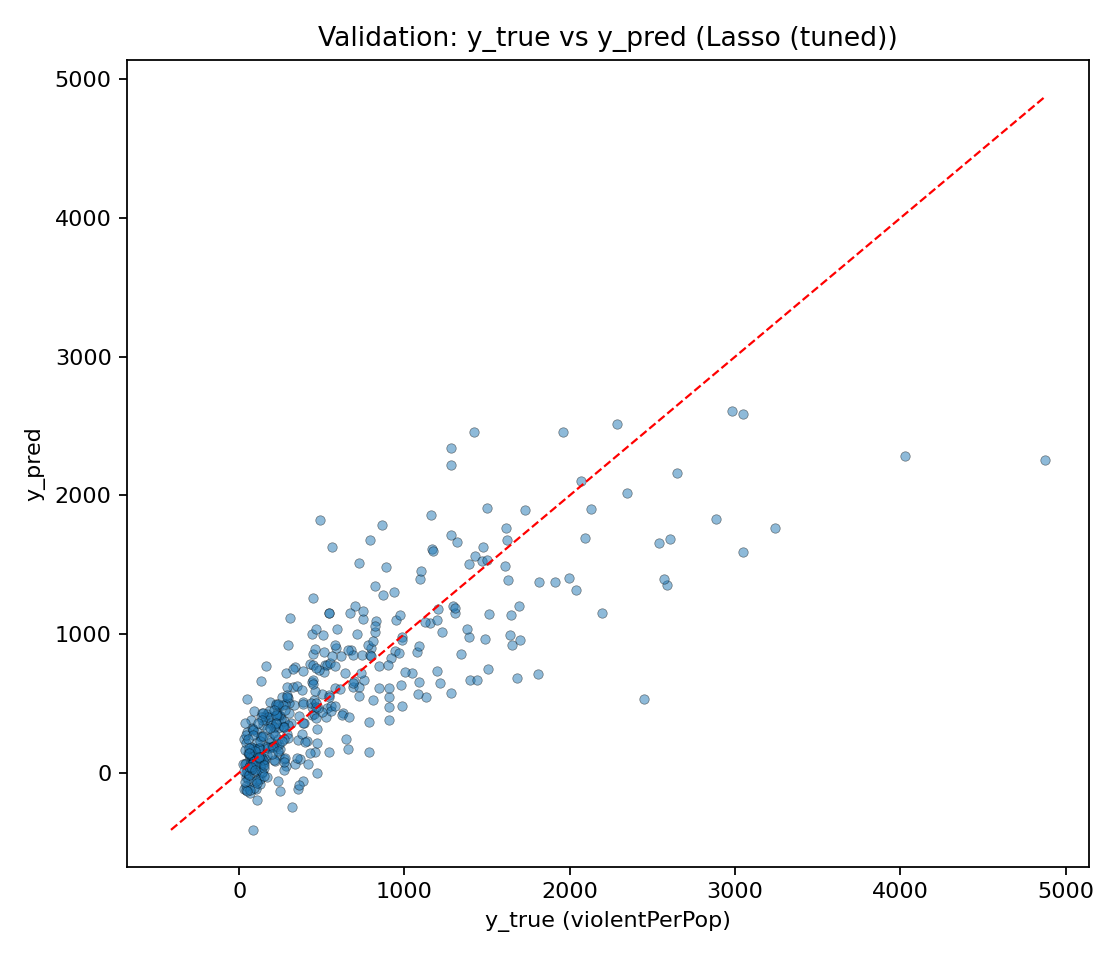

In [52]:
p = PLOT_DIR / "baseline_pred_vs_true_val.png"
display(Image.open(p))

Grafikon prikazuje odnos `y_true` i `y_pred` na validacionom skupu za **Lasso (tuned)**.  
Tačke blizu dijagonale (`y_true = y_pred`) označavaju dobre predikcije, dok veća odstupanja i outlieri ukazuju na teže primere.  
Primećuje se da pri većim vrednostima kriminala linearni model češće odstupa od dijagonale, što sugeriše da teže hvata nelinearnosti i ekstremne slučajeve (shrinkage efekat regularizacije može dodatno da “povuče” predikcije ka sredini).

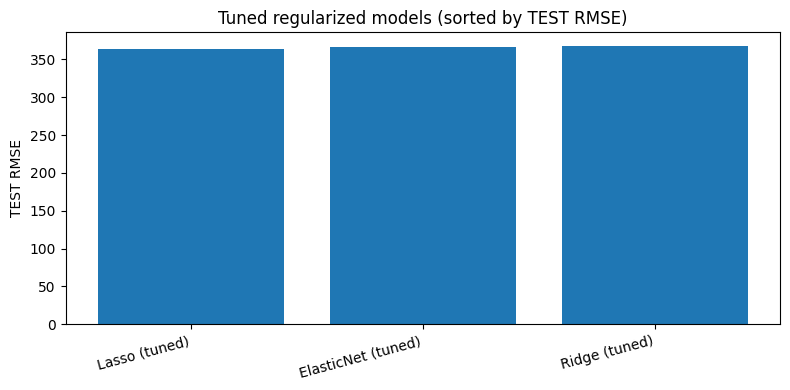

In [53]:
d = df_tuned_view.sort_values("test_rmse")

plt.figure(figsize=(8,4))
plt.bar(d["name"], d["test_rmse"])
plt.ylabel("TEST RMSE")
plt.title("Tuned regularized models (sorted by TEST RMSE)")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

**Zaključak:** Regularizovani modeli smanjuju uticaj multikolinearnosti i daju stabilnije procene.
Ridge obično najbolje stabilizuje kada postoji mnogo korelisanih feature-a, dok Lasso uvodi sparsity.
ElasticNet je kompromis i često radi dobro kada postoji “grupna” korelacija.

## 4) CatBoost (GBDT ansambl)

CatBoost je model iz porodice **Gradient Boosted Decision Trees (GBDT)**. On gradi ansambl plitkih stabala
tako što svako novo stablo pokušava da ispravi greške prethodnih modela (gradient boosting).
Prednosti u odnosu na linearne modele:
- hvata **nelinearnosti** i **interakcije** između atributa,
- robustan je na multikolinearnost,
- dobro radi na tabelarnim podacima i može da koristi kategorijske atributa (npr. `State`).

U projektu smo koristili dve CatBoost varijante:

- **CatBoost (baseline)**: hiperparametri su unapred fiksirani (referentna tačka bez tuninga).
- **CatBoost (tuned)**: hiperparametri su birani preko **k-fold cross-validation** na trening skupu (izbor po **CV RMSE**), a zatim je finalni model treniran uz **early stopping** na validacionom skupu.

Napomena:
- `best_iteration` označava iteraciju na kojoj je postignut najbolji rezultat na validacionom skupu; nakon prekida treniranja model se zadržava do te iteracije (*use_best_model*).
- Tuning po CV RMSE ne garantuje najbolji rezultat na test skupu (zbog šuma/outlier-a i ograničenog pretraživanja hiperparametara), pa se ponekad desi da baseline generalizuje bolje.

In [54]:
df_cb_tuned = pd.read_csv(CSV_DIR / "results_catboost_tuned.csv")
df_cb_baseline = pd.read_csv(CSV_DIR / "results_catboost.csv")
df_runs = pd.read_csv(CSV_DIR / "catboost_tuning_runs.csv")

display(df_cb_tuned)
display(df_cb_baseline)
df_runs.sort_values("cv_rmse").head(10)

name imputer scaler  is_tuned  \
0  CatBoost (tuned)  median   none      True   

                                         best_params     cv_rmse    val_rmse  \
0  {'depth': 4, 'learning_rate': 0.03, 'l2_leaf_r...  347.942581  398.198499   

      val_mae    val_r2  test_rmse    test_mae   test_r2  
0  249.026488  0.657589  364.34724  238.360181  0.618557

name imputer scaler  is_tuned  \
0  CatBoost (baseline)  median   none     False   

                                         best_params  cv_rmse    val_rmse  \
0  {'depth': 8, 'learning_rate': 0.05, 'l2_leaf_r...      NaN  391.390746   

      val_mae    val_r2   test_rmse    test_mae   test_r2  
0  238.017413  0.669197  351.775345  226.841725  0.644426

run  depth    lr    l2     cv_rmse  cv_rmse_std      cv_mae     cv_r2
0    3      4  0.03   3.0  347.942581    48.729791  226.292415  0.657842
1    5      4  0.05   3.0  349.012835    46.420210  227.708567  0.655998
2   10      6  0.03  10.0  349.341281    48.422580  225.927165  0.655842
3    4      4  0.03  10.0  349.953254    48.966789  226.369094  0.654163
4    8      6  0.02  10.0  350.100048    47.883052  225.993189  0.653794
5   12      6  0.05  10.0  350.494753    48.840770  225.496772  0.653857
6    2      4  0.02  10.0  350.593183    48.708937  227.727078  0.652340
7    1      4  0.02   3.0  350.944874    48.168609  228.683197  0.652388
8   16      8  0.03  10.0  351.994241    47.543140  225.956144  0.650366
9    6      4  0.05  10.0  352.073387    45.582815  228.418428  0.649938

* `df_runs` = svi kandidati hiperparametara i njihov CV RMSE

* `df_cb_tuned` = najbolji tuned model po cv_rmse (val/test metrike + best params)

* `df_cb_baseline` = najbolji catboost model po test_rmse

### Najvažniji CatBoost hiperparametri (kratko objašnjenje)

- **depth**: dubina stabla (veća = složeniji model, veći rizik od overfitting-a)
- **learning_rate**: korak u boosting-u (manji = stabilnije, ali treba više iteracija)
- **iterations**: broj stabala (kontroliše složenost ansambla)
- **l2_leaf_reg**: L2 regularizacija na listovima (smanjuje overfitting)
- **subsample / rsm**: slučajno uzorkovanje redova/feature-a (povećava generalizaciju)
- **early_stopping_rounds**: prekid ako nema poboljšanja na validaciji

In [55]:
import ast
bp_raw = df_cb_tuned.loc[0, "best_params"]

bp = ast.literal_eval(bp_raw) if isinstance(bp_raw, str) else bp_raw

bp_table = pd.DataFrame({"param": list(bp.keys()), "value": list(bp.values())})
bp_table

param       value
0           depth    4.000000
1   learning_rate    0.030000
2     l2_leaf_reg    3.000000
3        cv_folds    5.000000
4     cv_rmse_std   48.729791
5          cv_mae  226.292415
6           cv_r2    0.657842
7  best_iteration  190.000000

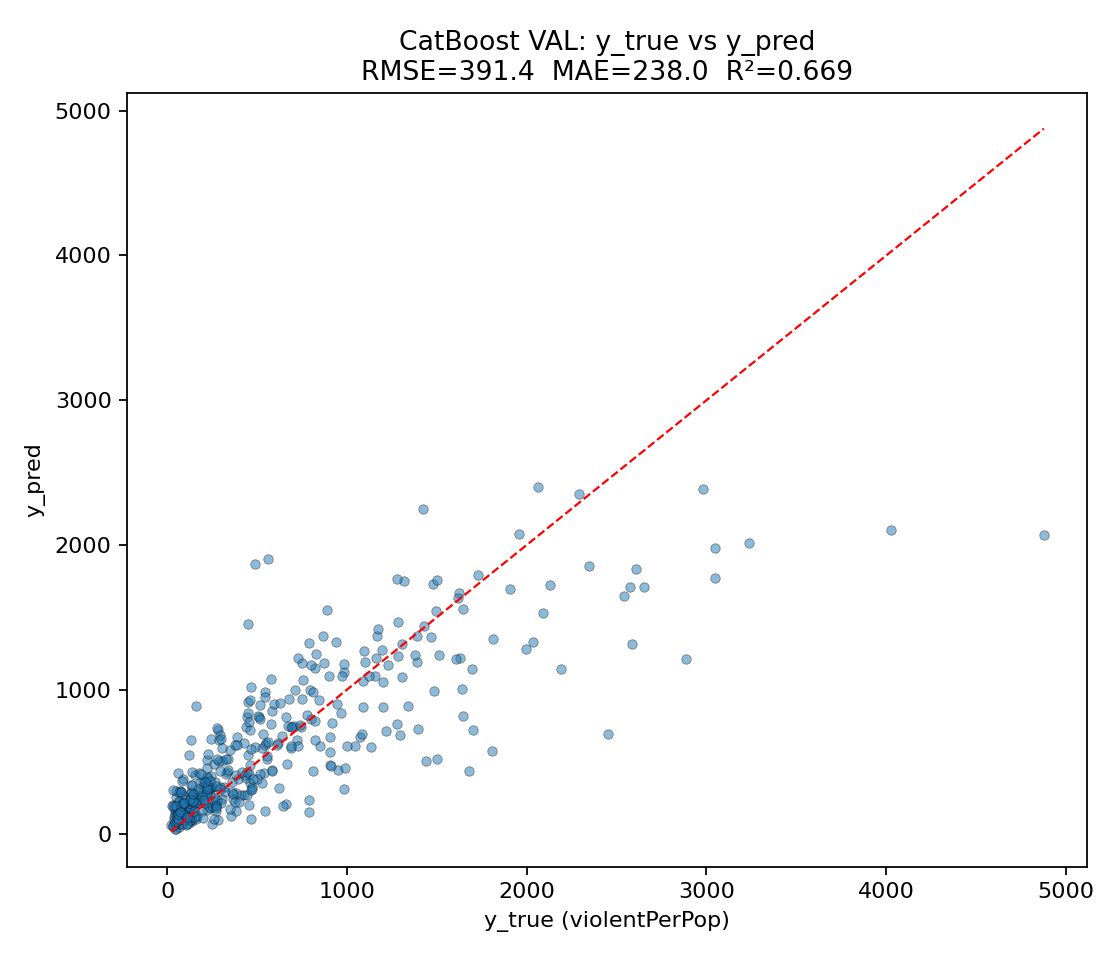

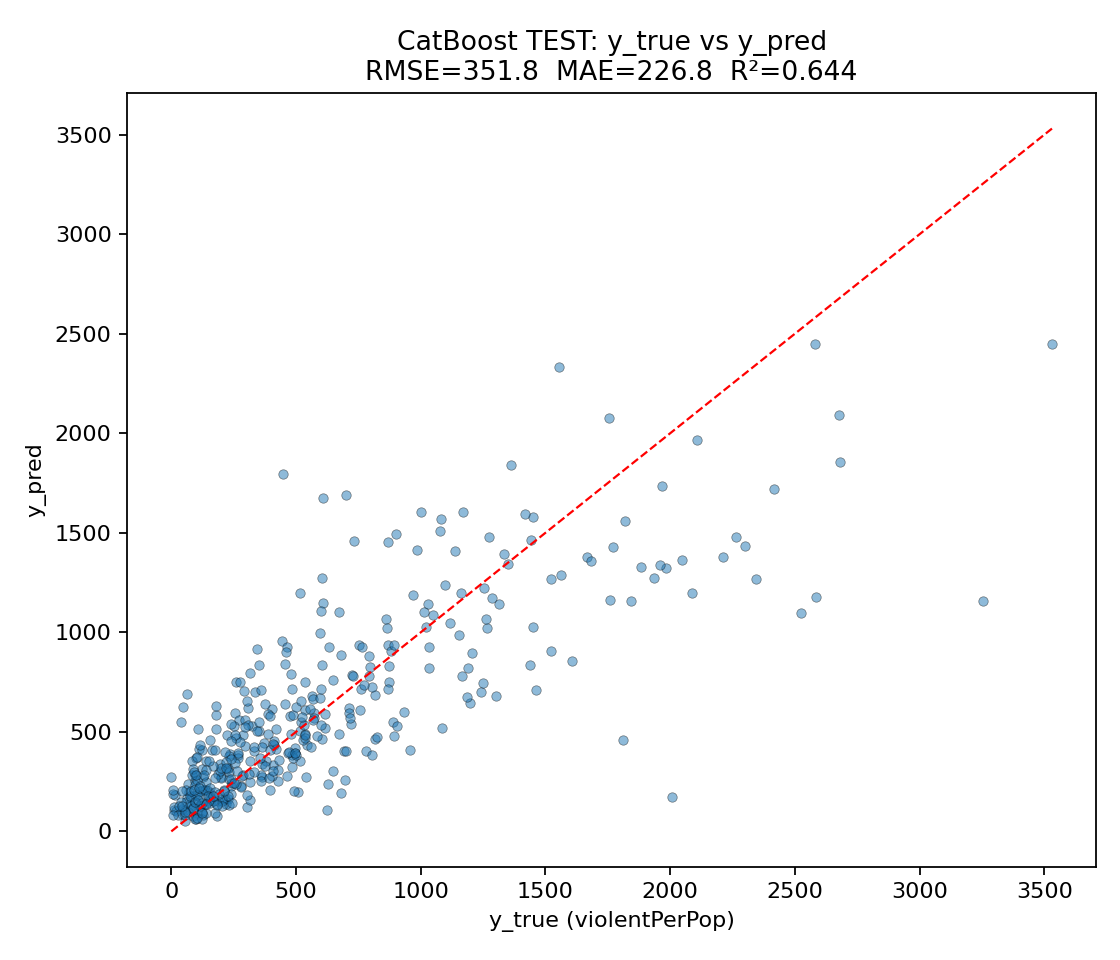

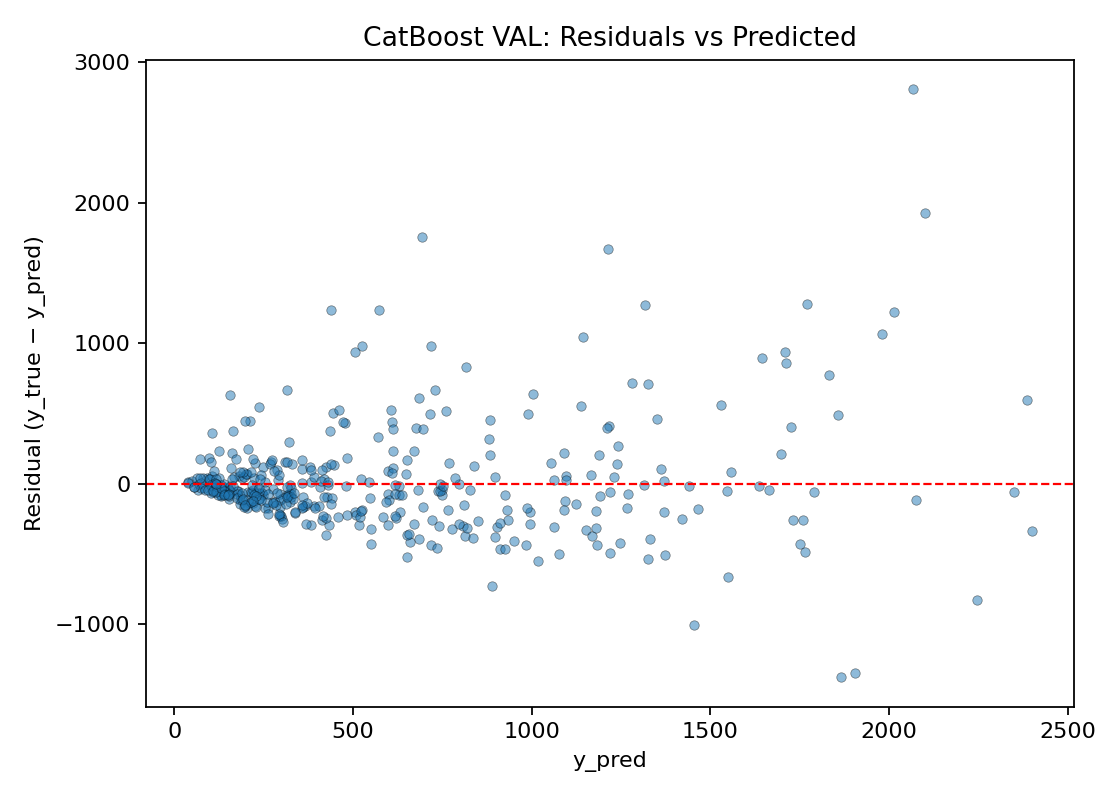

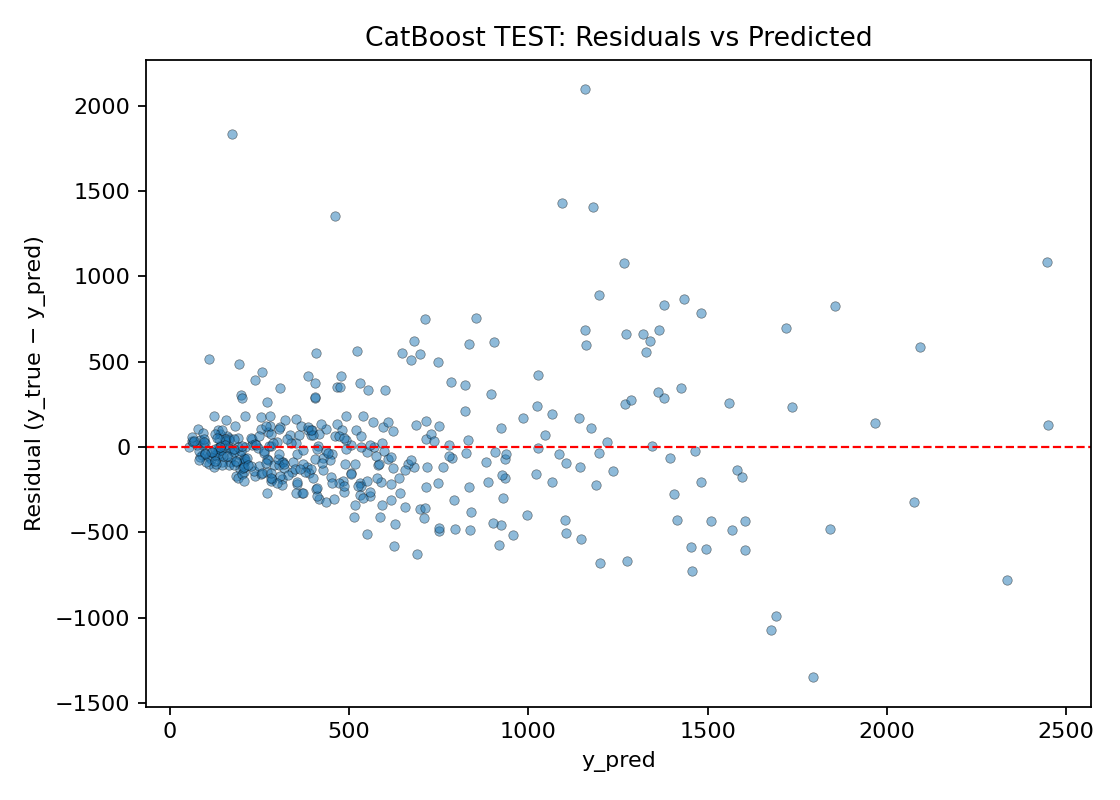

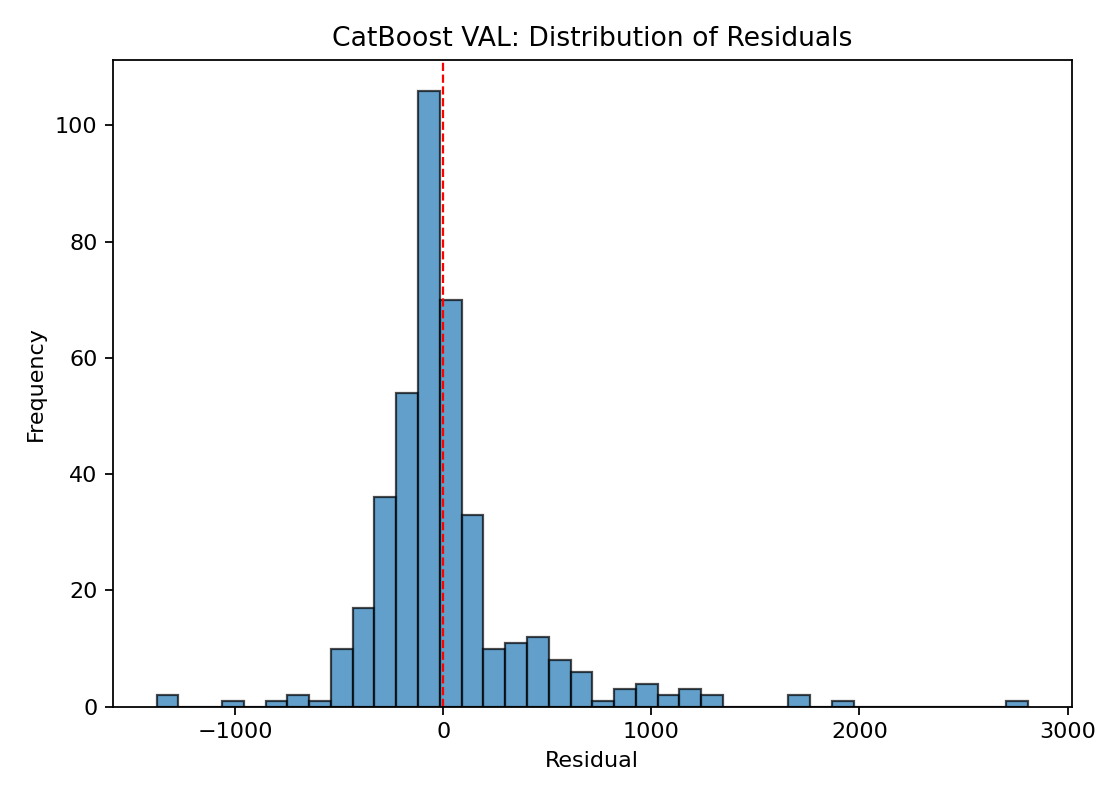

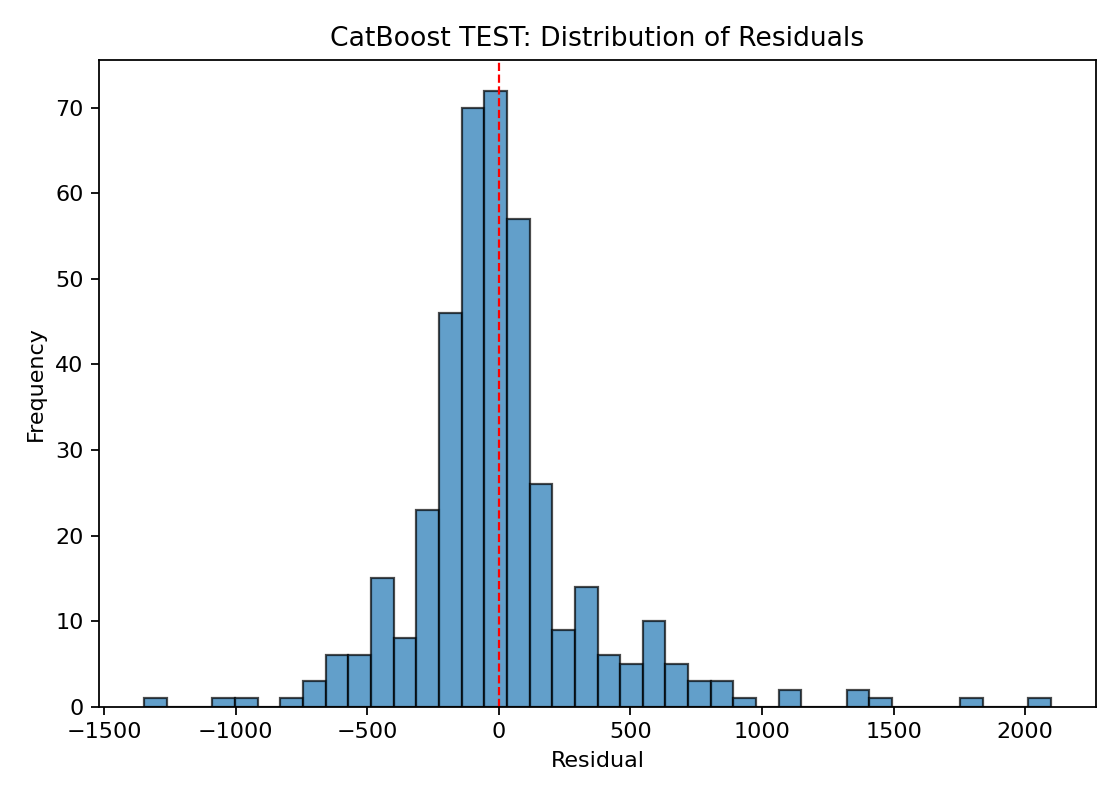

In [56]:
def show_img(name):
    p = PLOT_DIR / name
    if p.exists():
        display(Image.open(p))
    else:
        print("Missing:", p)

# Predikcije
for f in ["catboost_pred_vs_true_val.png", "catboost_pred_vs_true_test.png"]:
    show_img(f)

# Reziduali
for f in ["catboost_residuals_val.png", "catboost_residuals_test.png",
          "catboost_residual_hist_val.png", "catboost_residual_hist_test.png"]:
    show_img(f)

**Zaključak:** CatBoost može bolje da modeluje nelinearnosti i interakcije nego linearni modeli,
ali rangiranje modela može da se razlikuje između validacionog i test skupa (zbog šuma i outliera).
Zato prikazujemo i **baseline** i **tuned** varijantu, kao i grafike predikcija i reziduala,
da bismo ocenili i kvalitet fit-a i stabilnost generalizacije.

## 5) Interpretabilnost (Feature importance, Permutation importance, SHAP)

Cilj interpretabilnosti je da razumemo *koja obeležja* najviše utiču na predikciju i *u kom smeru*.

- **Feature importance (CatBoost)**: globalna važnost atributa iz modela
- **Permutation importance**: koliko performansa opada kada “izmešamo” jednu kolonu
- **SHAP**: objašnjenje doprinosa obeležja predikciji
  - globalno: $summary plot / mean(|SHAP|)$
  - lokalno: waterfall plot za pojedinačne primere

> U ovom izveštaju interpretabilnost je rađena nad **CatBoost (baseline)** modelom (najbolji po VAL i TEST).
> Plotovi i CSV fajlovi u ovoj sekciji su generisani skriptom `analyze_catboost.py`. 

In [57]:
fi = pd.read_csv(CSV_DIR / "catboost_feature_importance.csv").head(15)
perm = pd.read_csv(CSV_DIR / "catboost_permutation_importance_val.csv").head(15)
shap_g = pd.read_csv(CSV_DIR / "shap_global_importance.csv").head(15)

display(fi)
display(perm)
display(shap_g)

feature  importance
0           pctKids2Par    7.055957
1   pctKidsBornNevrMarr    6.659008
2               pct2Par    5.034360
3              pctBlack    2.897729
4      kidsBornNevrMarr    2.824328
5       pctPopDenseHous    2.618861
6                 State    2.482821
7              pctWhite    2.358966
8          persHomeless    2.097927
9               pctWdiv    1.791992
10         pctFemDivorc    1.791562
11          blackPerCap    1.566929
12        pct12-17w2Par    1.559488
13          houseVacant    1.400068
14          otherPerCap    1.395583

feature  importance_mean  importance_std
0   pctKidsBornNevrMarr        38.541645        4.090898
1           pctKids2Par        36.661161        4.695514
2               pct2Par        17.822998        3.152767
3              pctBlack        16.248488        2.940906
4              pctWhite        13.931354        3.192220
5      kidsBornNevrMarr        11.335574        2.173826
6               pctWdiv        10.783091        2.140813
7       pctPopDenseHous         9.920941        1.913468
8                 State         9.396870        2.382734
9          pctFemDivorc         7.095706        2.039946
10         pctAllDivorc         6.132316        2.829349
11          houseVacant         6.019984        1.659467
12        pct12-17w2Par         5.905677        1.210758
13        pctMaleNevMar         5.404888        1.491291
14    pctSmallHousUnits         4.782818        1.350645

feature  mean_abs_shap
0           pctKids2Par      53.681423
1   pctKidsBornNevrMarr      48.923962
2              pctBlack      36.283489
3               pct2Par      29.144567
4              pctWhite      28.697651
5       pctPopDenseHous      27.927060
6      kidsBornNevrMarr      26.156825
7               pctWdiv      24.480101
8                 State      23.995625
9          pctFemDivorc      19.952373
10         pctAllDivorc      16.979718
11           pctPoverty      16.579537
12          houseVacant      16.490861
13         persHomeless      16.053533
14          blackPerCap      15.085454

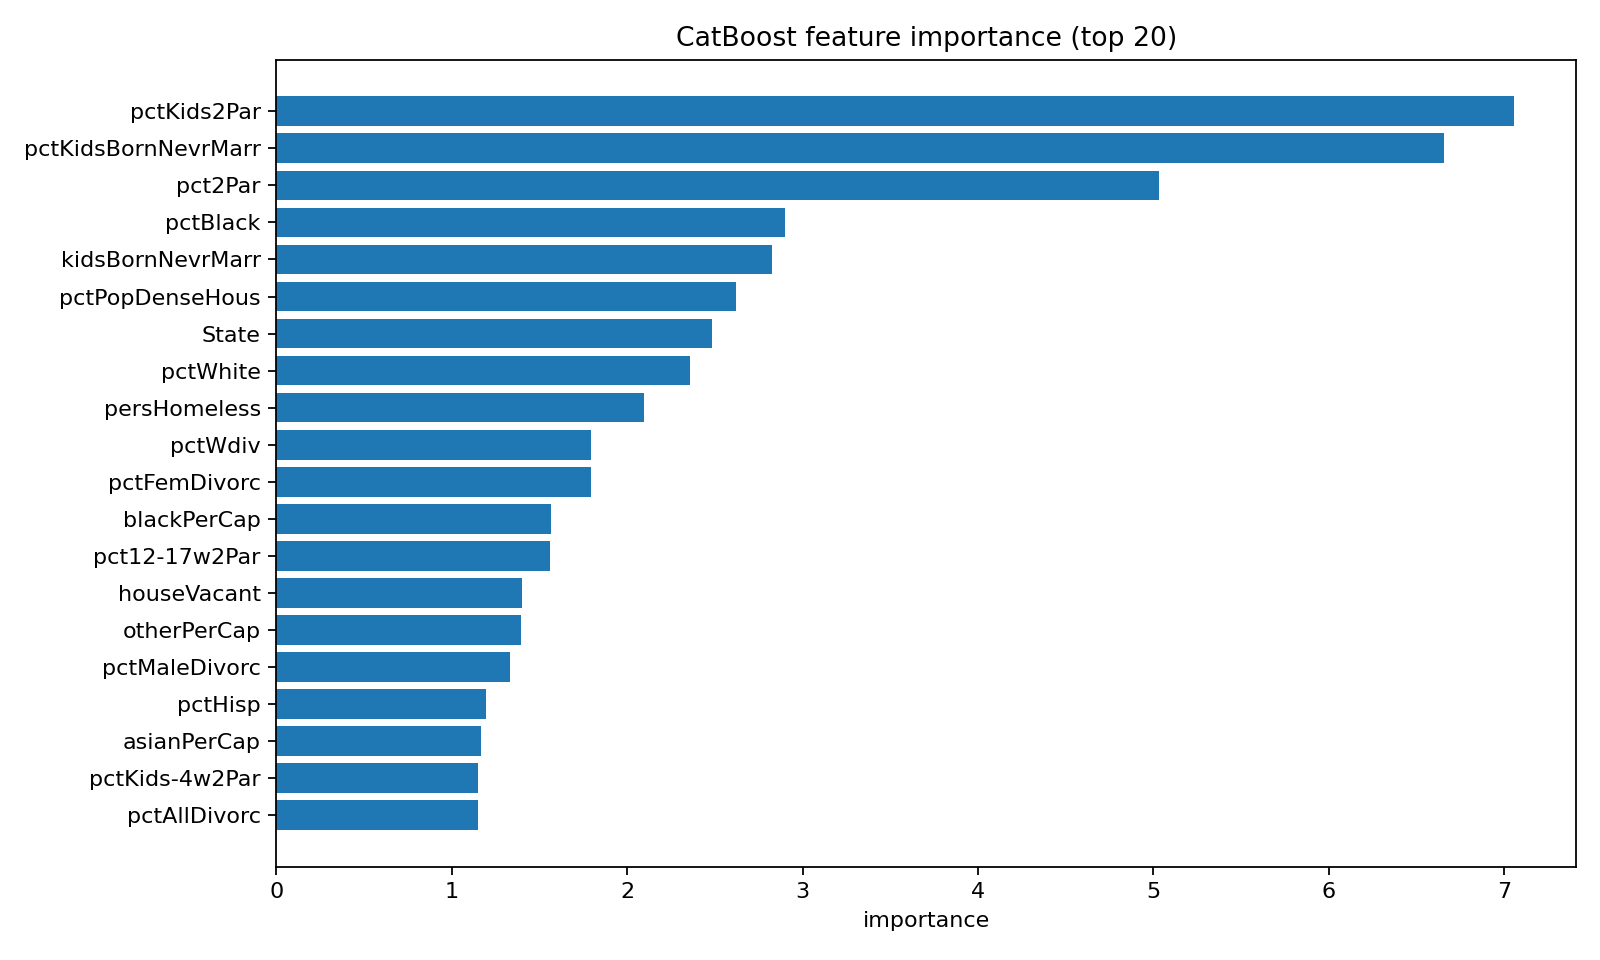

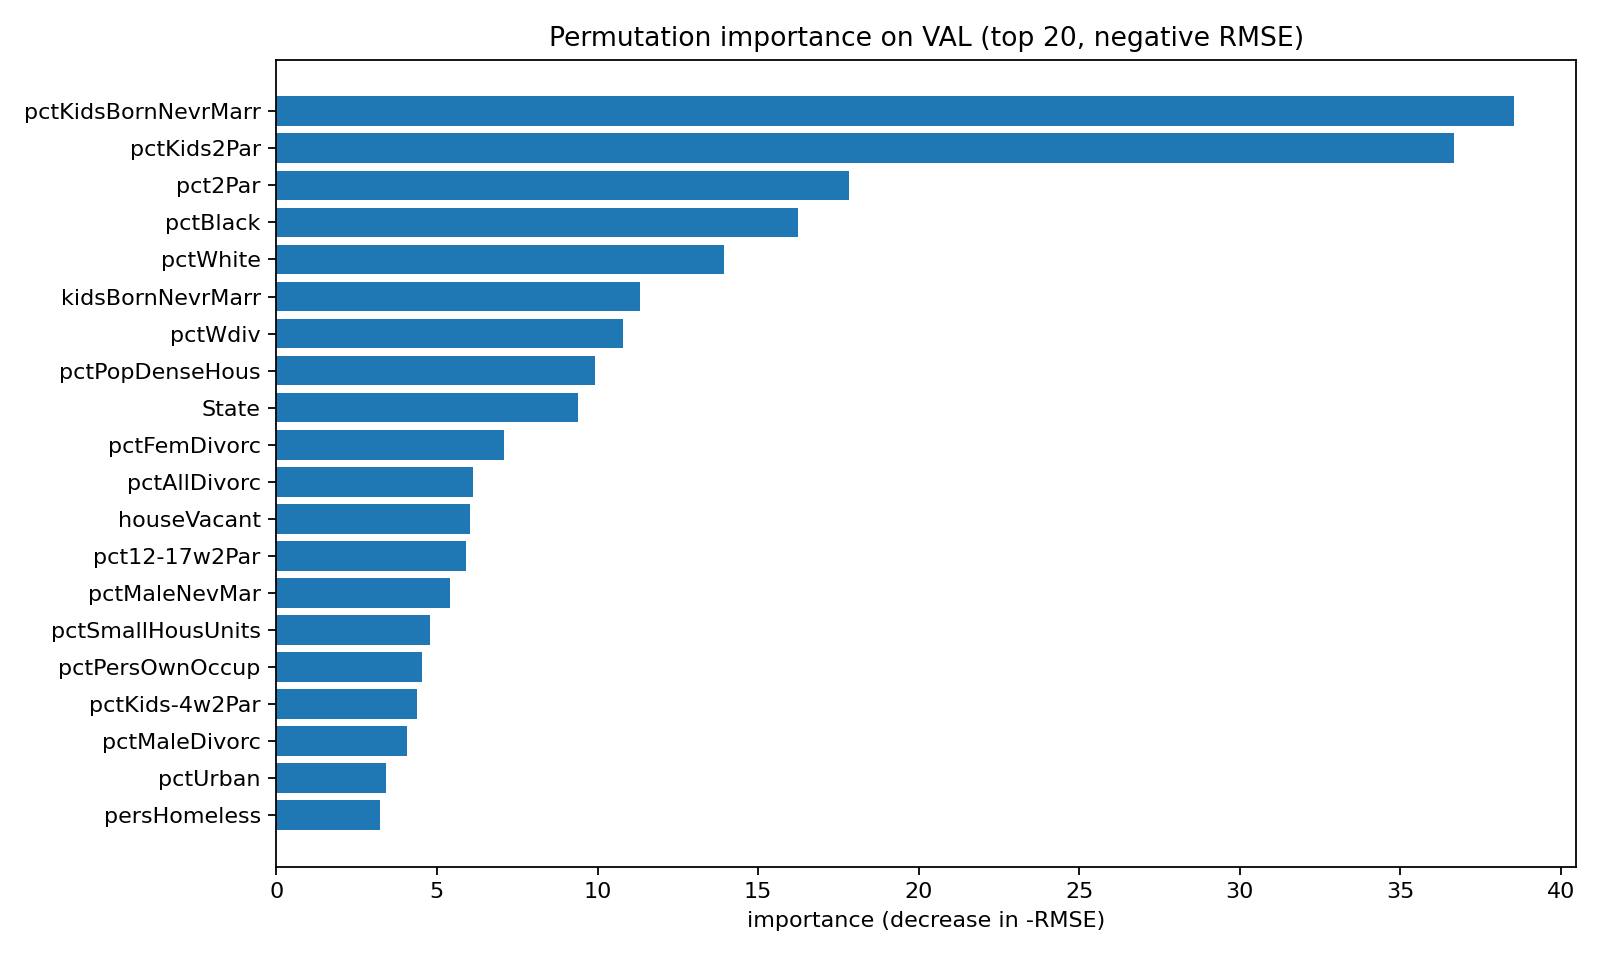

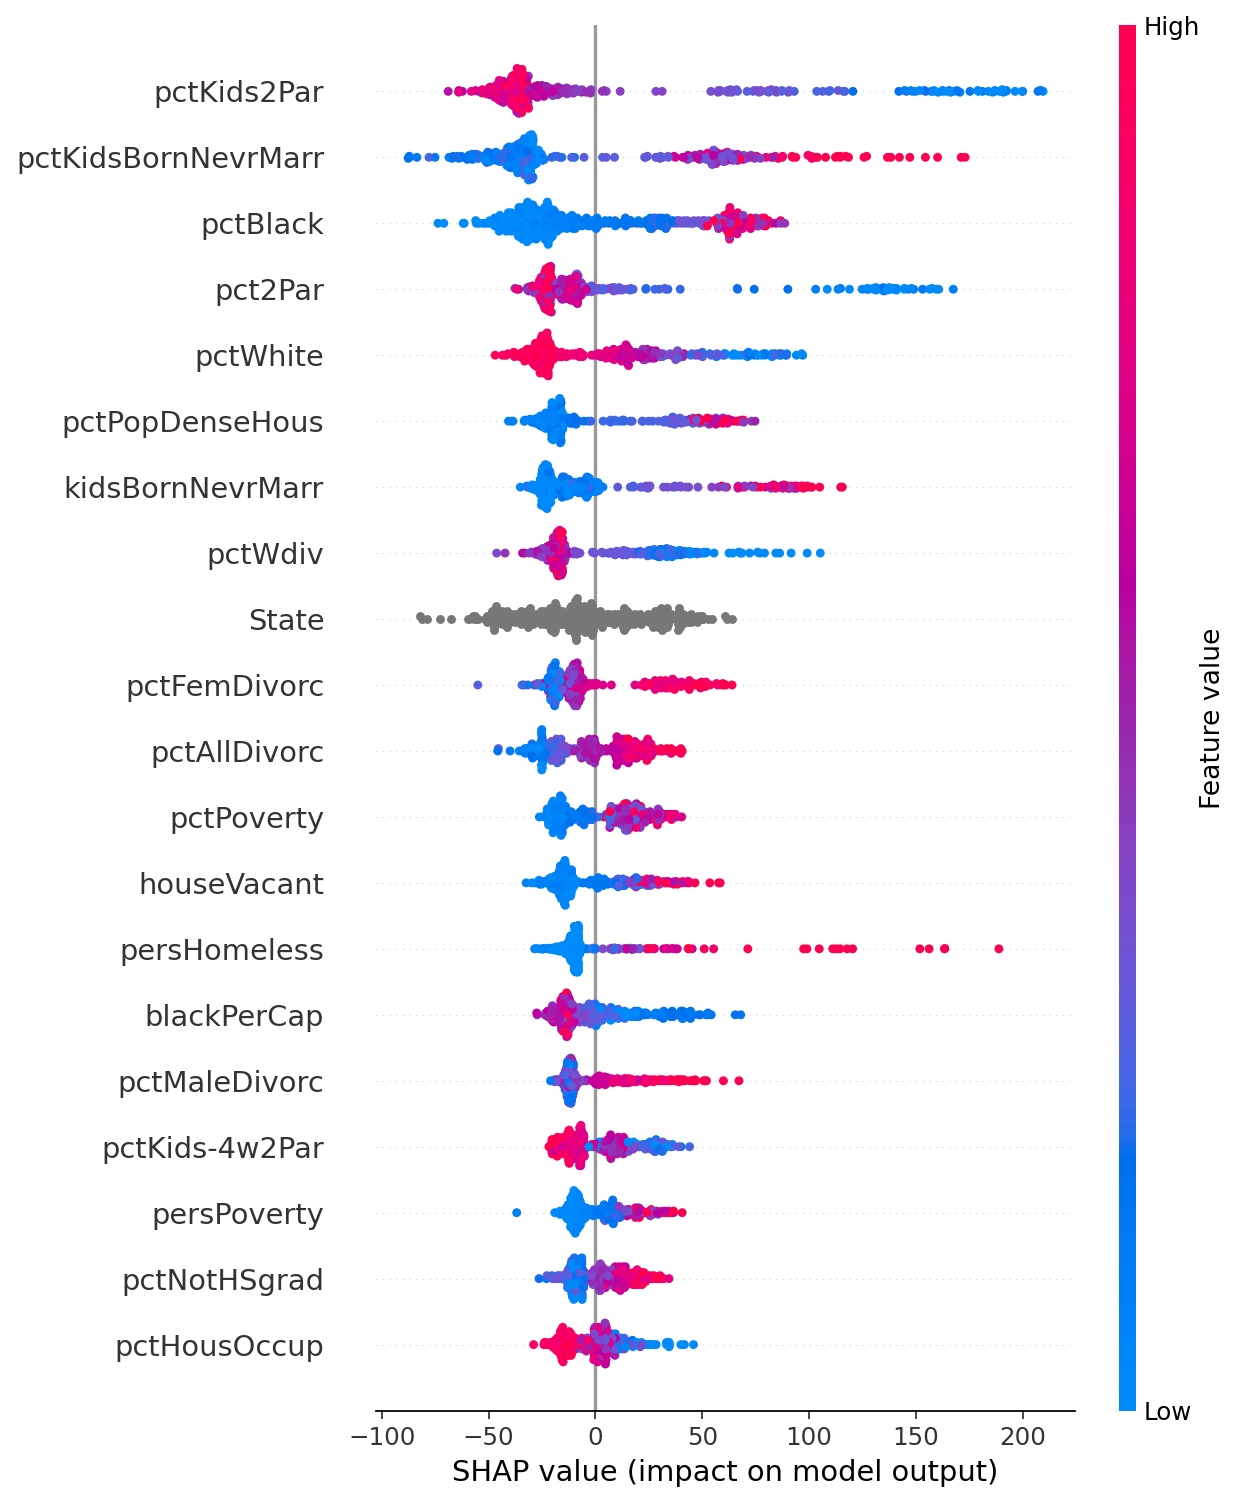

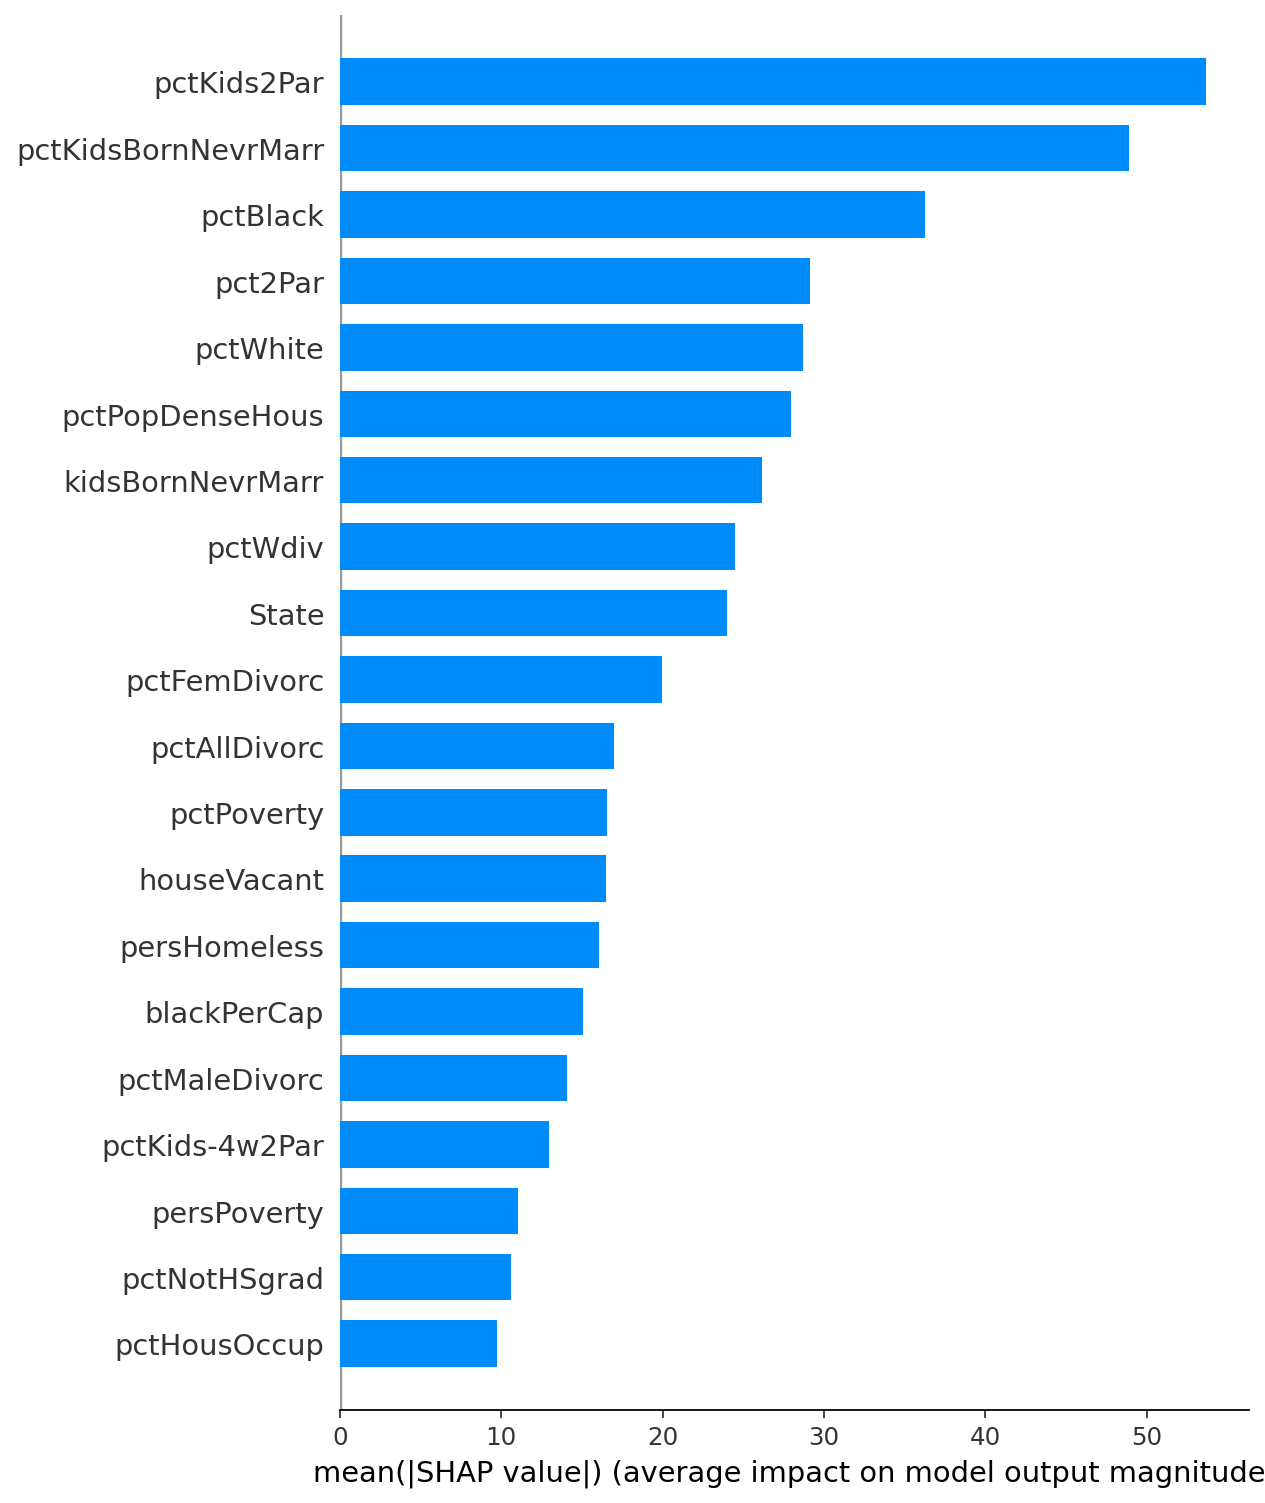

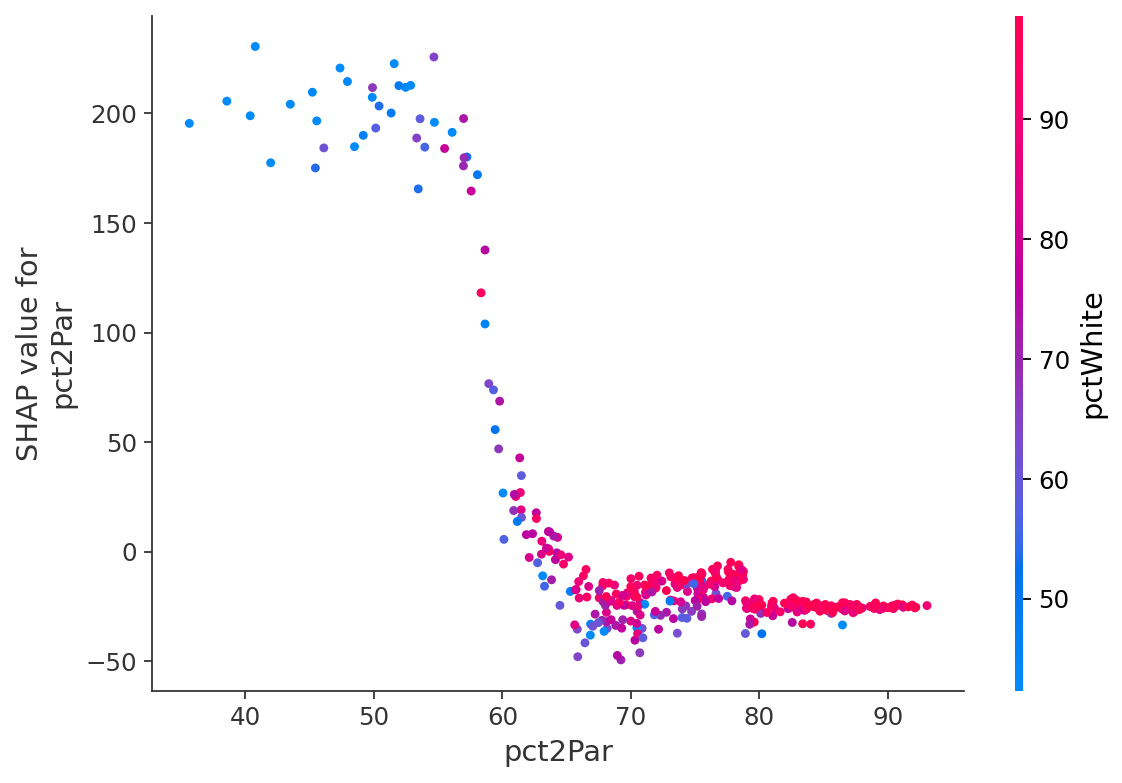

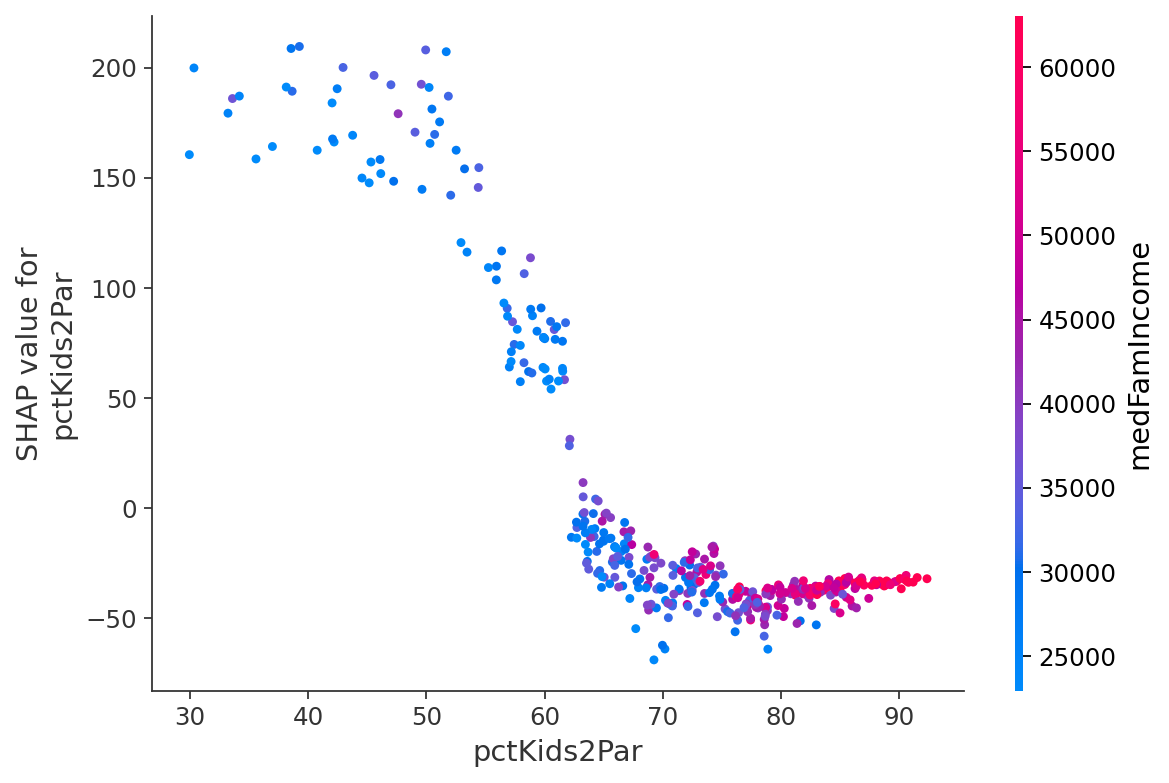

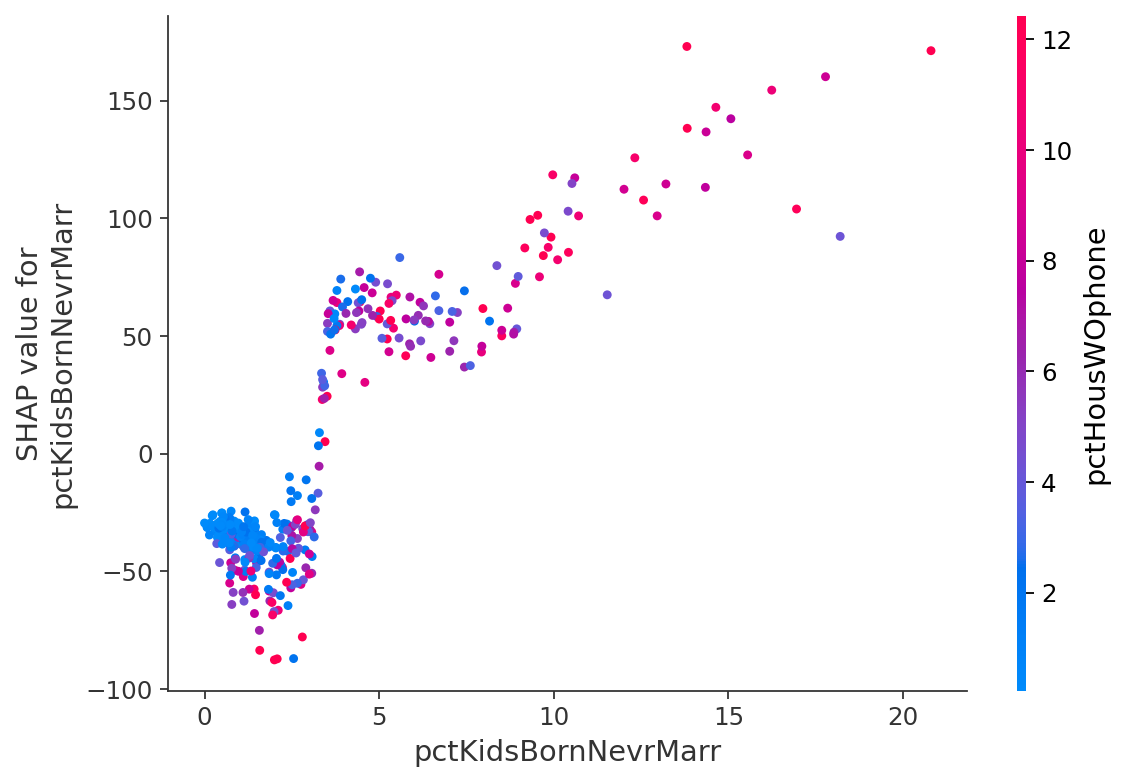

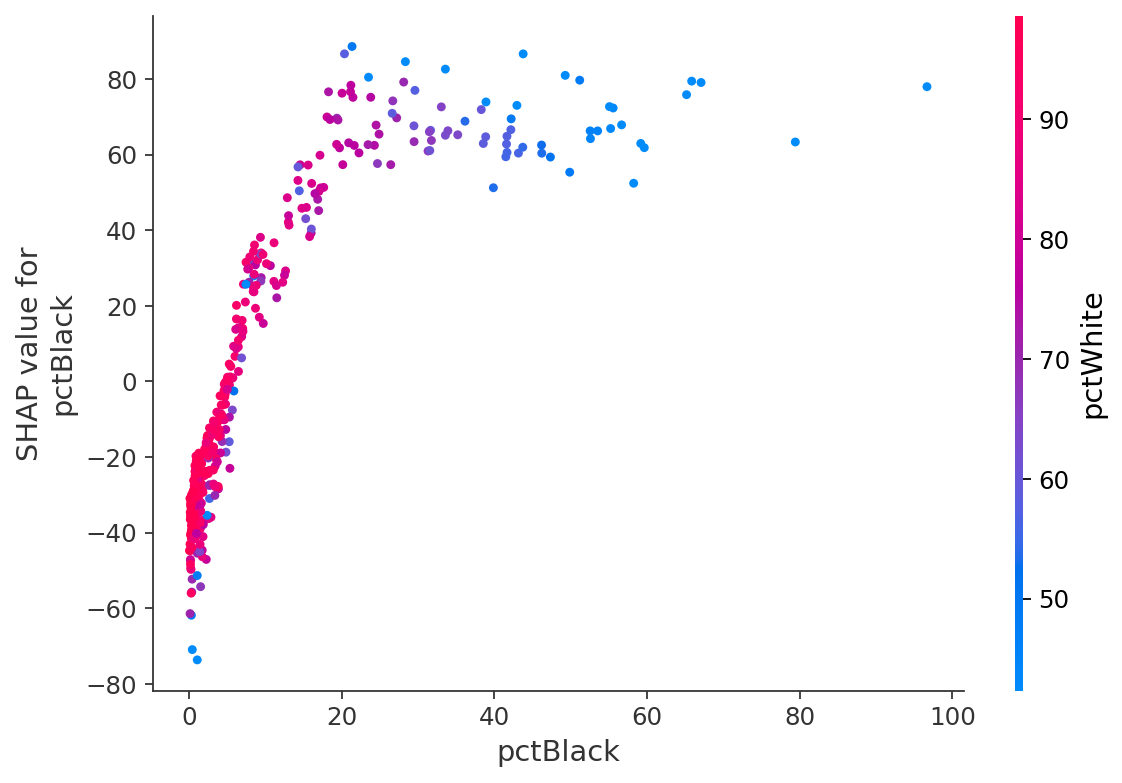

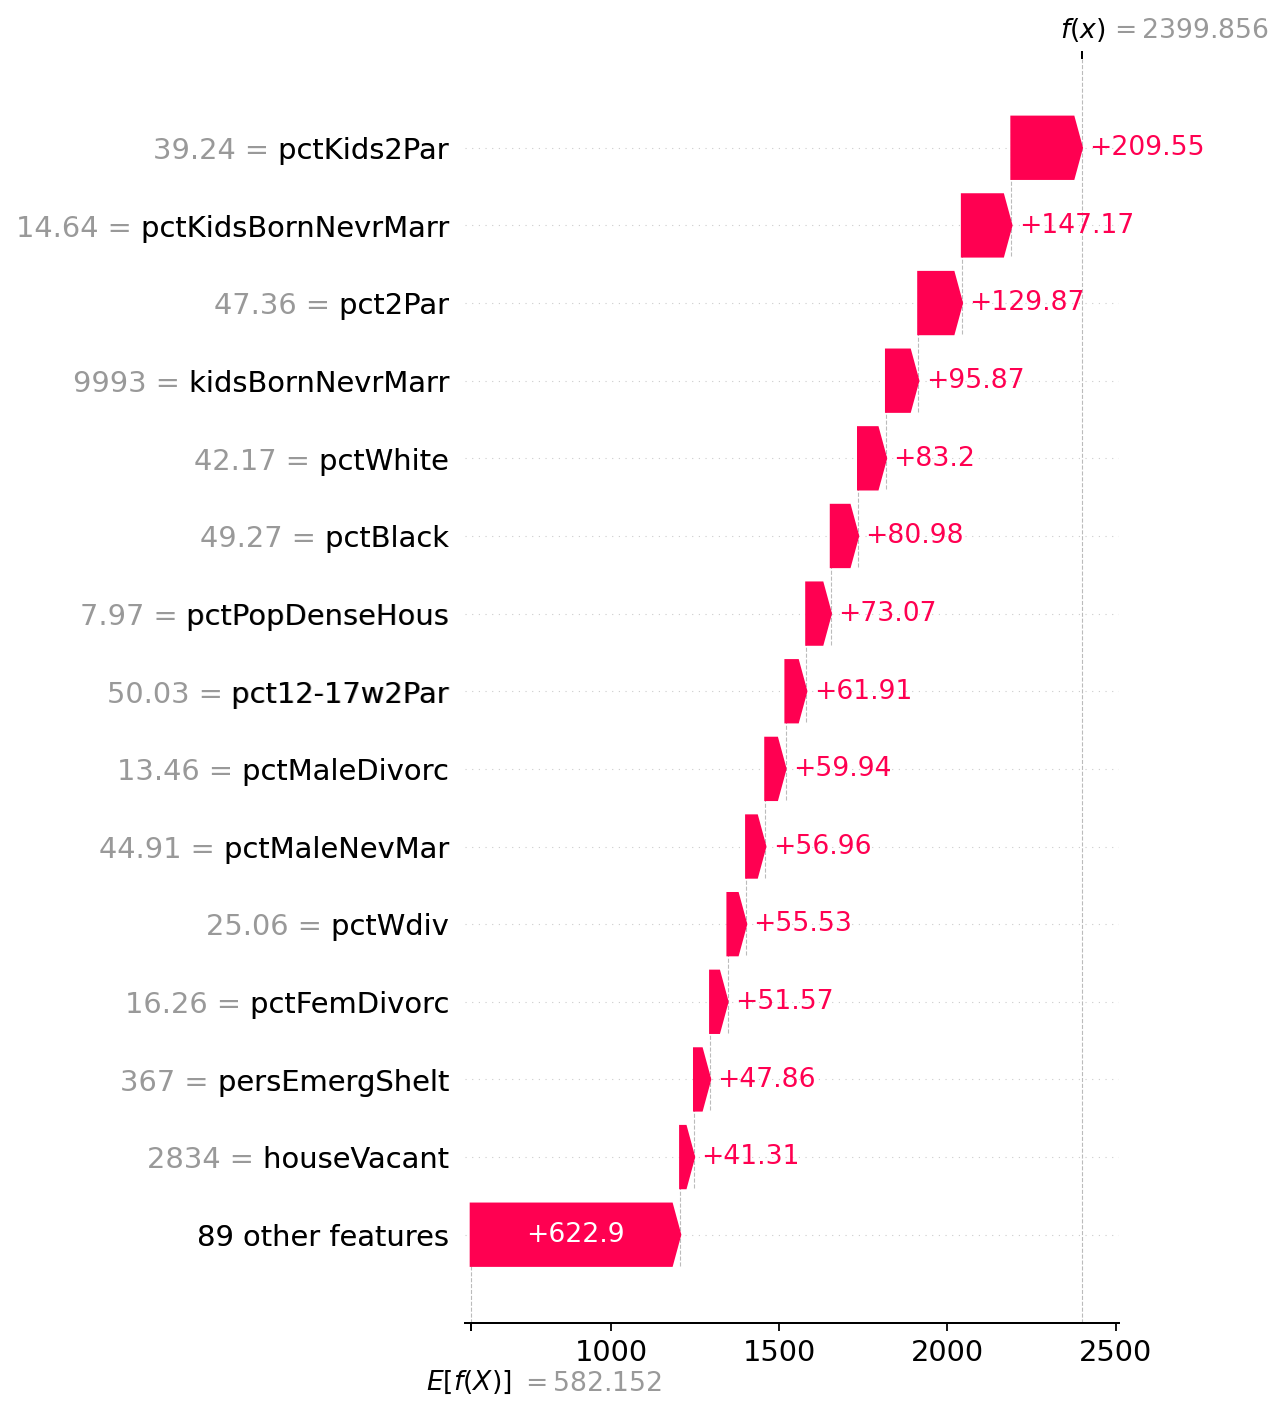

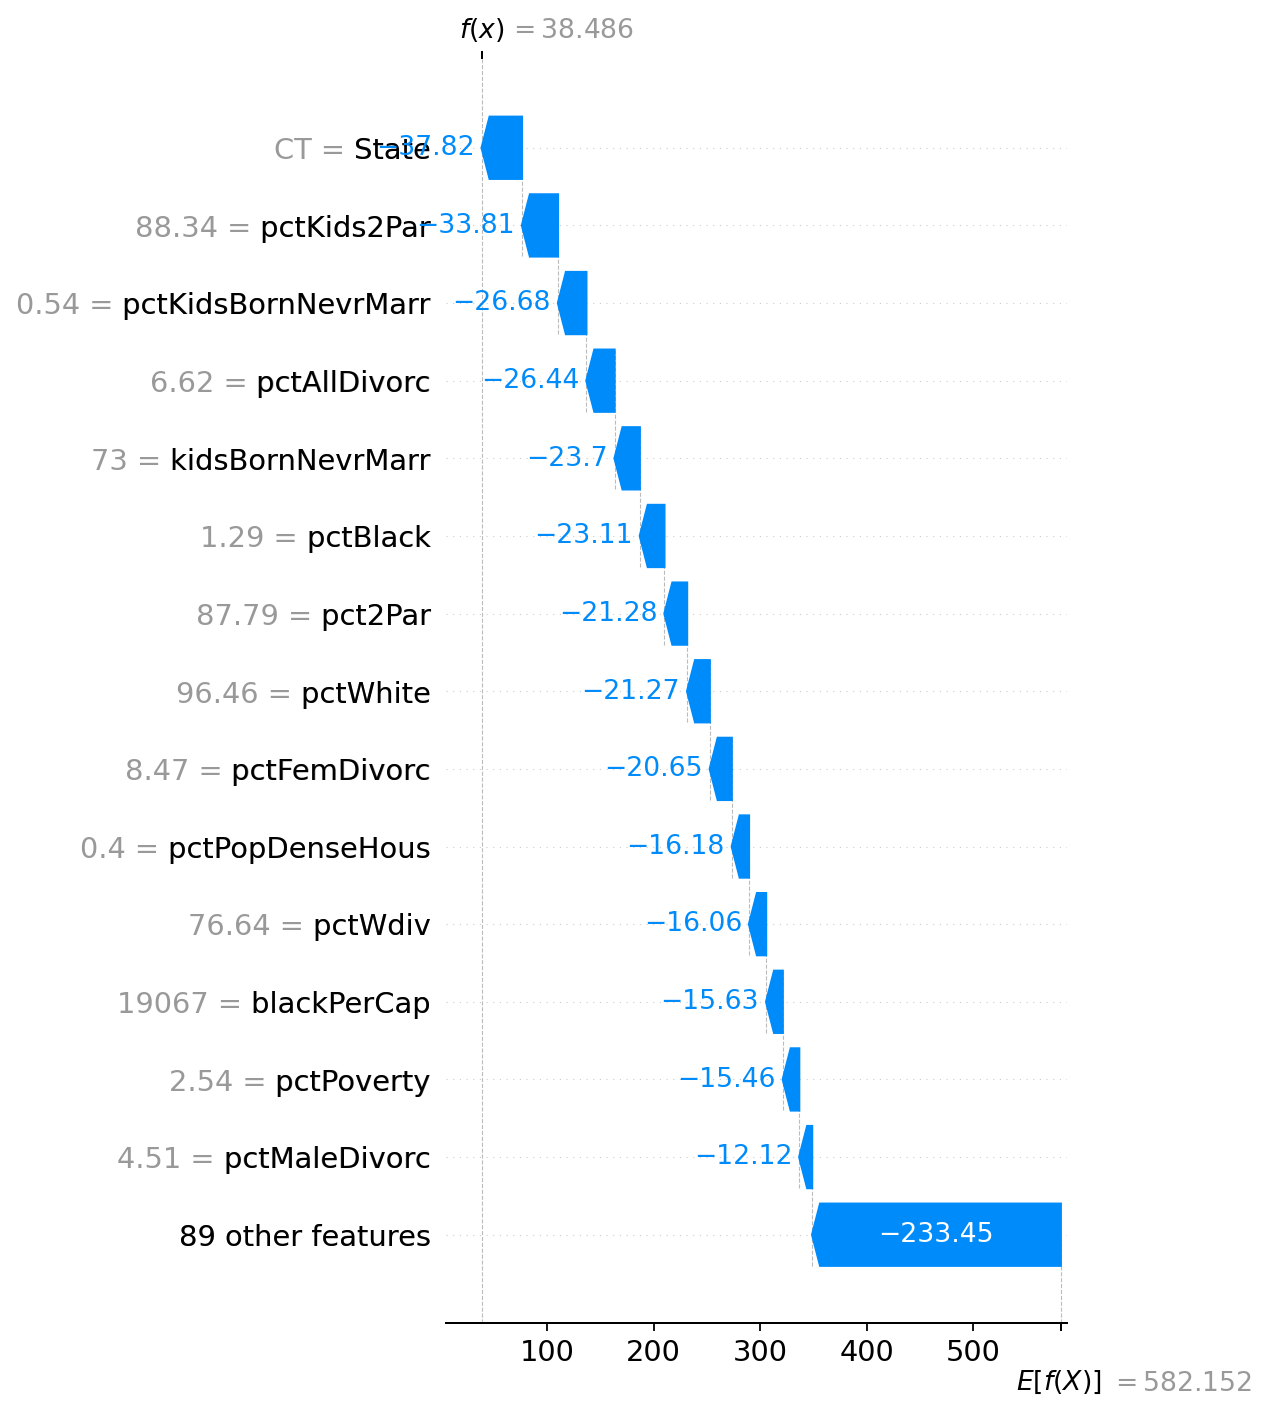

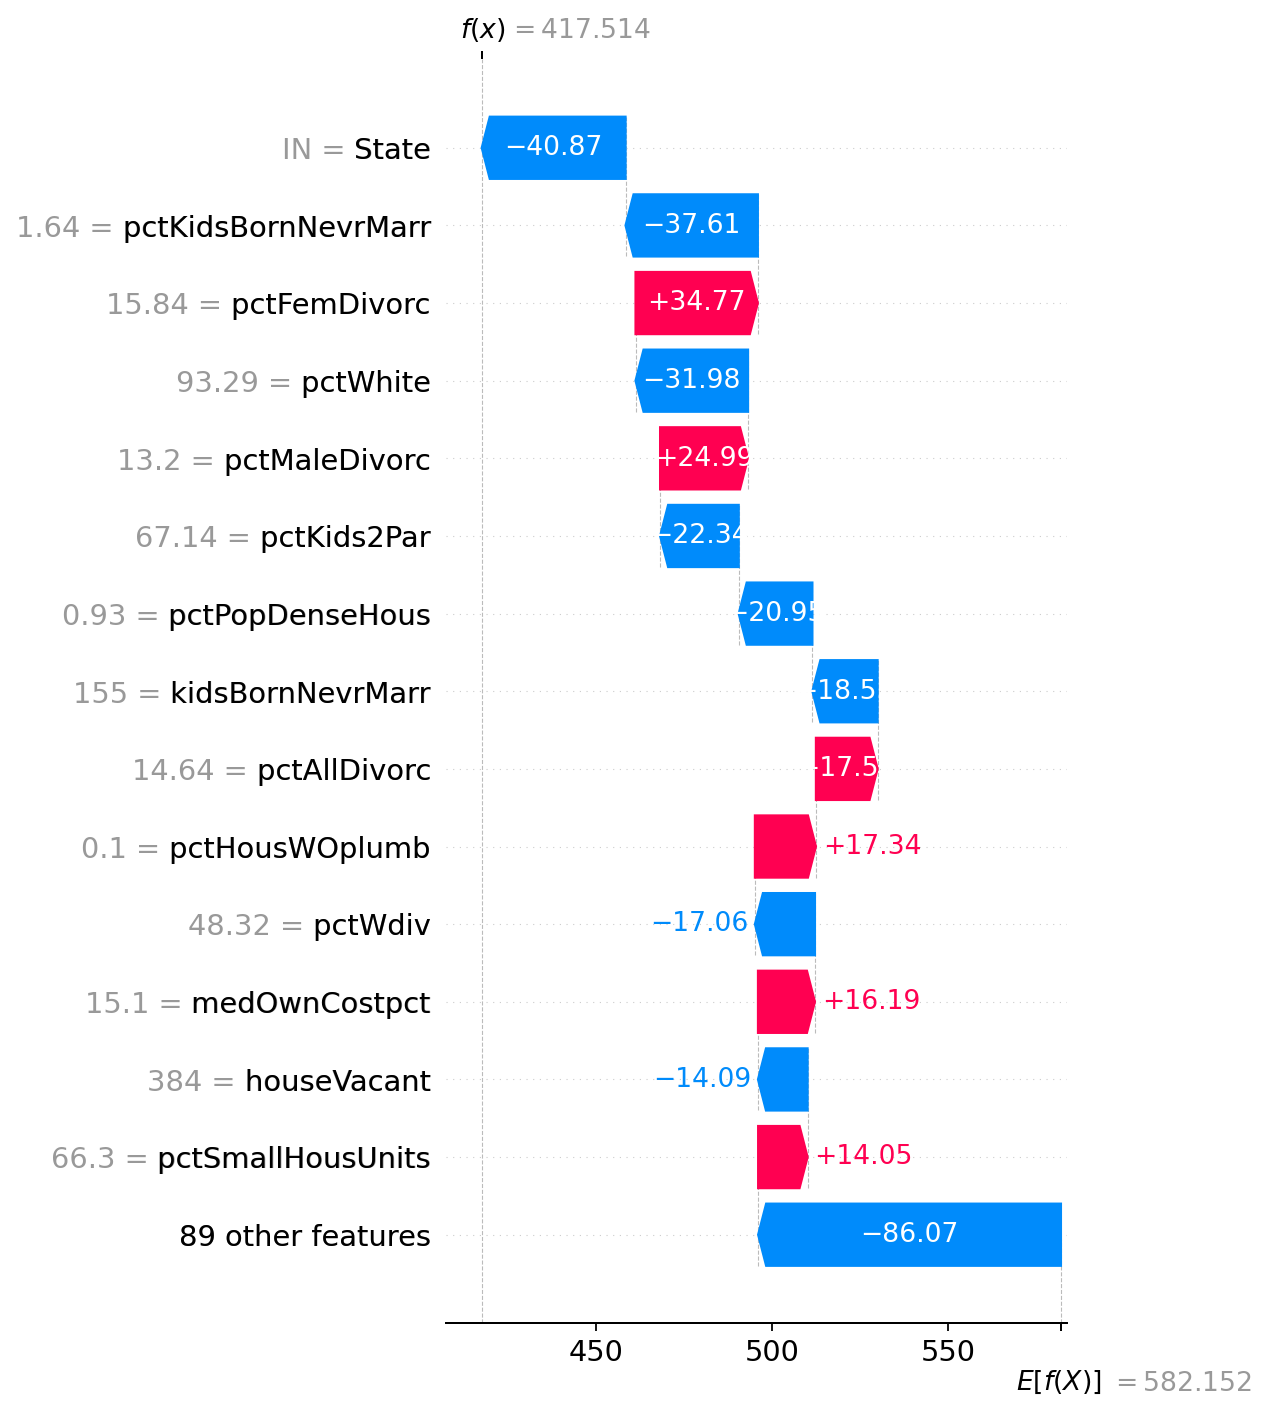

In [58]:
def show_img(name):
    p = PLOT_DIR / name
    if p.exists():
        display(Image.open(p))
    else:
        print("Missing:", p)

for f in [
    "catboost_feature_importance.png",
    "catboost_permutation_importance_val.png",
    "shap_summary_beeswarm.png",
    "shap_summary_bar.png",
    "shap_dependence_pct2Par.png",
    "shap_dependence_pctKids2Par.png",
    "shap_dependence_pctKidsBornNevrMarr.png",
    "shap_dependence_pctBlack.png",
    "shap_waterfall_high.png",
    "shap_waterfall_low.png",
    "shap_waterfall_median.png",
]:
    show_img(f)

### Zaključak interpretabilnosti (Feature importance + Permutation + SHAP)

Tri pristupa interpretabilnosti (CatBoost *feature importance*, *permutation importance* i SHAP) daju konzistentnu sliku:  
najveći deo prediktivne moći dolazi iz promenljivih koje opisuju **strukturu porodice i decu** (`pctKids2Par`, `pctKidsBornNevrMarr`, `pct2Par`), zatim iz **demografskih/strukturnih** faktora (`pctBlack`, `pctWhite`, `State`) i indikatora **urbanizacije/stambenih uslova** (`pctPopDenseHous`, `houseVacant`).

Na SHAP *summary (beeswarm)* grafiku se vidi smer efekata:
- veće vrednosti `pctKidsBornNevrMarr` tipično imaju **pozitivan SHAP** (podižu predikciju nasilnog kriminala),
- veće vrednosti `pctKids2Par` i `pct2Par` tipično imaju **negativan SHAP** (smanjuju predikciju),
- `pctBlack` i `pctWhite` imaju uočljiv doprinos, dok `State` hvata razlike između saveznih država koje nisu direktno objašnjene ostalim atributima.

SHAP *dependence* grafici potvrđuju da odnosi nisu strogo linearni i da postoje interakcije:
- za `pct2Par` i `pctKids2Par` vidi se izražen “prelom” (oko ~60–65%), nakon čega veće vrednosti dominantno **snižavaju** predikciju (SHAP prelazi u negativno),
- za `pctBlack` doprinos raste nelinearno (jak rast pri manjim vrednostima, zatim stabilizacija),
- boja na grafiku ukazuje na interakcije:  
  `pct2Par` i `pctBlack` su obojeni sa `pctWhite`, `pctKids2Par` sa `medFamIncome`, a `pctKidsBornNevrMarr` sa `pctHousWOphone`, što sugeriše da se efekat ovih promenljivih menja u zavisnosti od socio-ekonomskog/strukturnog konteksta.

Lokalna objašnjenja (*waterfall*) prate isti obrazac:
- primer sa visokom predikcijom dobija najveće pozitivne doprinose kada su indikatori “stabilnije porodične strukture” niži (npr. niži `pctKids2Par` / `pct2Par`) i kada je `pctKidsBornNevrMarr` veći,
- primer sa niskom predikcijom tipično ima suprotne doprinose (visok `pctKids2Par` / `pct2Par` “vuče” predikciju naniže), uz dodatne efekte `State` i drugih faktora.

**Napomena:** interpretacije opisuju obrasce u podacima koje je model naučio i ne predstavljaju kauzalne zaključke (posebno za demografske promenljive).

## 6) Poređenje svih modela (linearni vs CatBoost)

Upoređujemo najbolje modele po validacionim i test metrikama (RMSE/R²).

- `leaderboard_all.csv` sadrži sve pokrete (razne imputere/scalere i modele).
- `best_per_model.csv` sadrži najbolju varijantu za svaki model.

Pošto imamo dve CatBoost varijante (**baseline** i **tuned**), one se pojavljuju kao dva odvojena modela (različit `name`).

In [59]:
df_best = pd.read_csv(CSV_DIR / "best_per_model.csv")
df_lead = pd.read_csv(CSV_DIR / "leaderboard_all.csv")

display(df_best.sort_values("test_rmse"))   # najbolje po TEST RMSE
cols = ["name","imputer","scaler","is_tuned","val_rmse","val_r2","test_rmse","test_r2","source_file"]
display(df_lead.sort_values(["val_rmse","test_rmse"])[cols].head(10))
display(df_lead.sort_values(["test_rmse","val_rmse"])[cols].head(10))

name imputer    scaler  is_tuned  \
0        CatBoost (baseline)  median      none     False   
2  ElasticNet(a=0.01,l1=0.5)    mice  standard     False   
3             Ridge(alpha=1)    mice  standard     False   
4              Lasso (tuned)    mice  standard      True   
1           CatBoost (tuned)  median      none      True   
5         ElasticNet (tuned)    mice  standard      True   
6              Ridge (tuned)    mice  standard      True   
7          Lasso(alpha=0.01)    mice  standard     False   
8                        OLS    mice    robust     False   

                                         best_params     cv_rmse    val_rmse  \
0  {'depth': 8, 'learning_rate': 0.05, 'l2_leaf_r...         NaN  391.390746   
2                                                NaN  370.541469  398.377657   
3                                                NaN  366.435321  400.529063   
4   {'model__alpha': np.float64(0.0610540229658533)}  364.293361  402.136089   
1  {'depth': 4, 'learning_rate': 0.03, 'l2_leaf_r...  347.942581  398.198499   
5  {'model__alpha': np.float64(0.001), 'model__l1...  364.355449  402.817878   
6   {'model__alpha': np.float64(0.0517947467923121)}  364.396356  403.309163   
7                                                NaN  364.573070  403.472464   
8                                                NaN  364.750868  403.805376   

      val_mae    val_r2   test_rmse    test_mae   test_r2  \
0  238.017413  0.669197  351.775345  226.841725  0.644426   
2  260.898532  0.657281  354.500119  233.578398  0.638896   
3  264.507302  0.653569  360.570430  237.052841  0.626424   
4  266.677643  0.650784  364.241344  240.352674  0.618778   
1  249.026488  0.657589  364.347240  238.360181  0.618557   
5  267.323650  0.649599  366.151529  240.940156  0.614769   
6  267.811799  0.648743  367.256137  241.686274  0.612441   
7  267.892788  0.648459  367.573667  241.967798  0.611771   
8  268.204700  0.647878  368.330613  242.320580  0.610170   

                    source_file  
0          results_catboost.csv  
2  results_linear_baselines.csv  
3  results_linear_baselines.csv  
4  results_linear_baselines.csv  
1    results_catboost_tuned.csv  
5  results_linear_baselines.csv  
6  results_linear_baselines.csv  
7  results_linear_baselines.csv  
8  results_linear_baselines.csv

name imputer    scaler  is_tuned    val_rmse  \
0        CatBoost (baseline)  median      none     False  391.390746   
1           CatBoost (tuned)  median      none      True  398.198499   
2  ElasticNet(a=0.01,l1=0.5)    mice  standard     False  398.377657   
3  ElasticNet(a=0.01,l1=0.5)  median  standard     False  398.390174   
4  ElasticNet(a=0.01,l1=0.5)     knn  standard     False  398.411031   
5             Ridge(alpha=1)    mice  standard     False  400.529063   
6             Ridge(alpha=1)  median  standard     False  400.542935   
7             Ridge(alpha=1)     knn  standard     False  400.565599   
8  ElasticNet(a=0.01,l1=0.5)    mice    robust     False  401.028626   
9  ElasticNet(a=0.01,l1=0.5)  median    robust     False  401.042323   

     val_r2   test_rmse   test_r2                   source_file  
0  0.669197  351.775345  0.644426          results_catboost.csv  
1  0.657589  364.347240  0.618557    results_catboost_tuned.csv  
2  0.657281  354.500119  0.638896  results_linear_baselines.csv  
3  0.657259  354.534044  0.638827  results_linear_baselines.csv  
4  0.657223  354.586404  0.638720  results_linear_baselines.csv  
5  0.653569  360.570430  0.626424  results_linear_baselines.csv  
6  0.653545  360.598931  0.626365  results_linear_baselines.csv  
7  0.653506  360.642915  0.626273  results_linear_baselines.csv  
8  0.652705  361.763233  0.623948  results_linear_baselines.csv  
9  0.652681  361.796603  0.623878  results_linear_baselines.csv

name imputer    scaler  is_tuned    val_rmse  \
0         CatBoost (baseline)  median      none     False  391.390746   
2   ElasticNet(a=0.01,l1=0.5)    mice  standard     False  398.377657   
3   ElasticNet(a=0.01,l1=0.5)  median  standard     False  398.390174   
4   ElasticNet(a=0.01,l1=0.5)     knn  standard     False  398.411031   
5              Ridge(alpha=1)    mice  standard     False  400.529063   
6              Ridge(alpha=1)  median  standard     False  400.542935   
7              Ridge(alpha=1)     knn  standard     False  400.565599   
8   ElasticNet(a=0.01,l1=0.5)    mice    robust     False  401.028626   
9   ElasticNet(a=0.01,l1=0.5)  median    robust     False  401.042323   
10  ElasticNet(a=0.01,l1=0.5)     knn    robust     False  401.065040   

      val_r2   test_rmse   test_r2                   source_file  
0   0.669197  351.775345  0.644426          results_catboost.csv  
2   0.657281  354.500119  0.638896  results_linear_baselines.csv  
3   0.657259  354.534044  0.638827  results_linear_baselines.csv  
4   0.657223  354.586404  0.638720  results_linear_baselines.csv  
5   0.653569  360.570430  0.626424  results_linear_baselines.csv  
6   0.653545  360.598931  0.626365  results_linear_baselines.csv  
7   0.653506  360.642915  0.626273  results_linear_baselines.csv  
8   0.652705  361.763233  0.623948  results_linear_baselines.csv  
9   0.652681  361.796603  0.623878  results_linear_baselines.csv  
10  0.652641  361.848027  0.623772  results_linear_baselines.csv

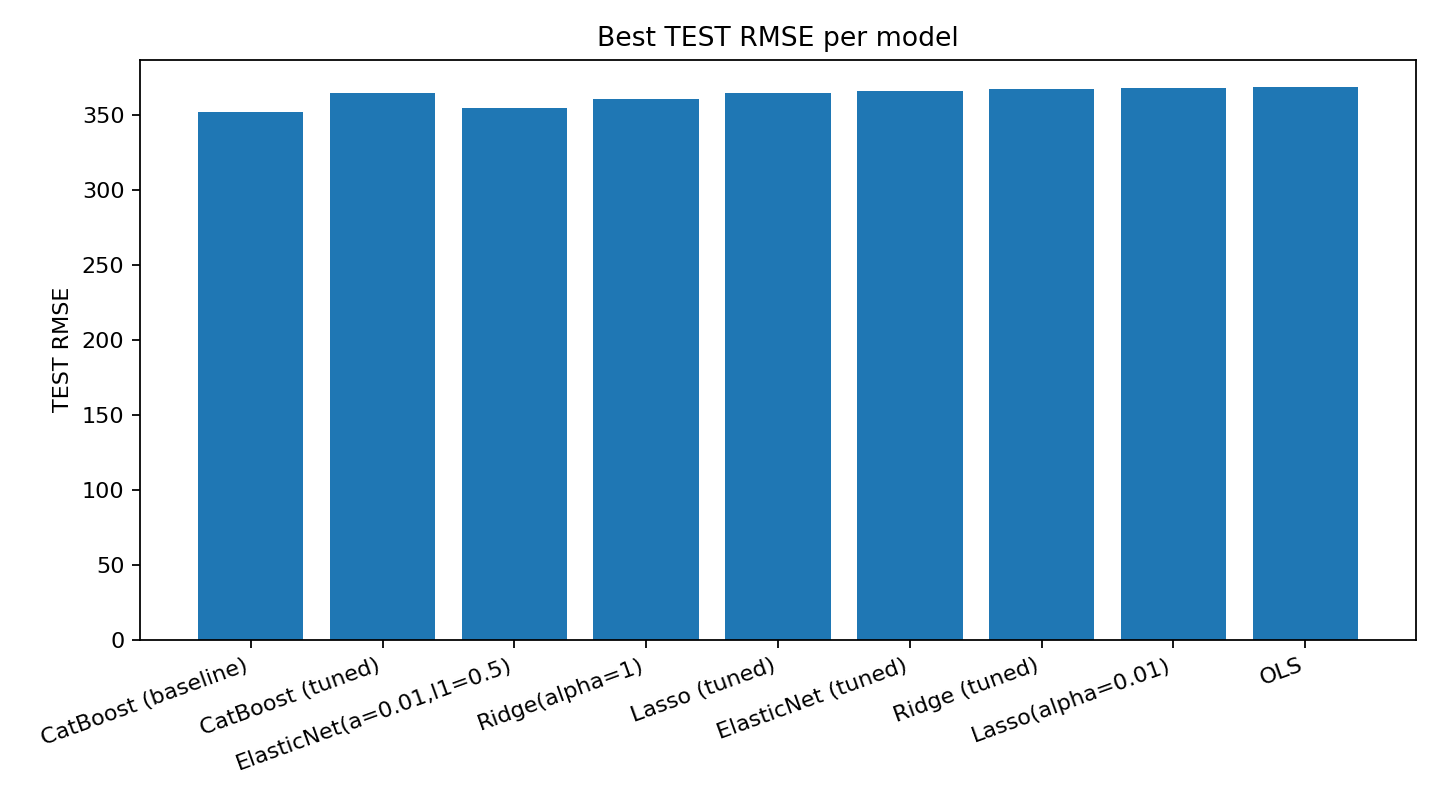

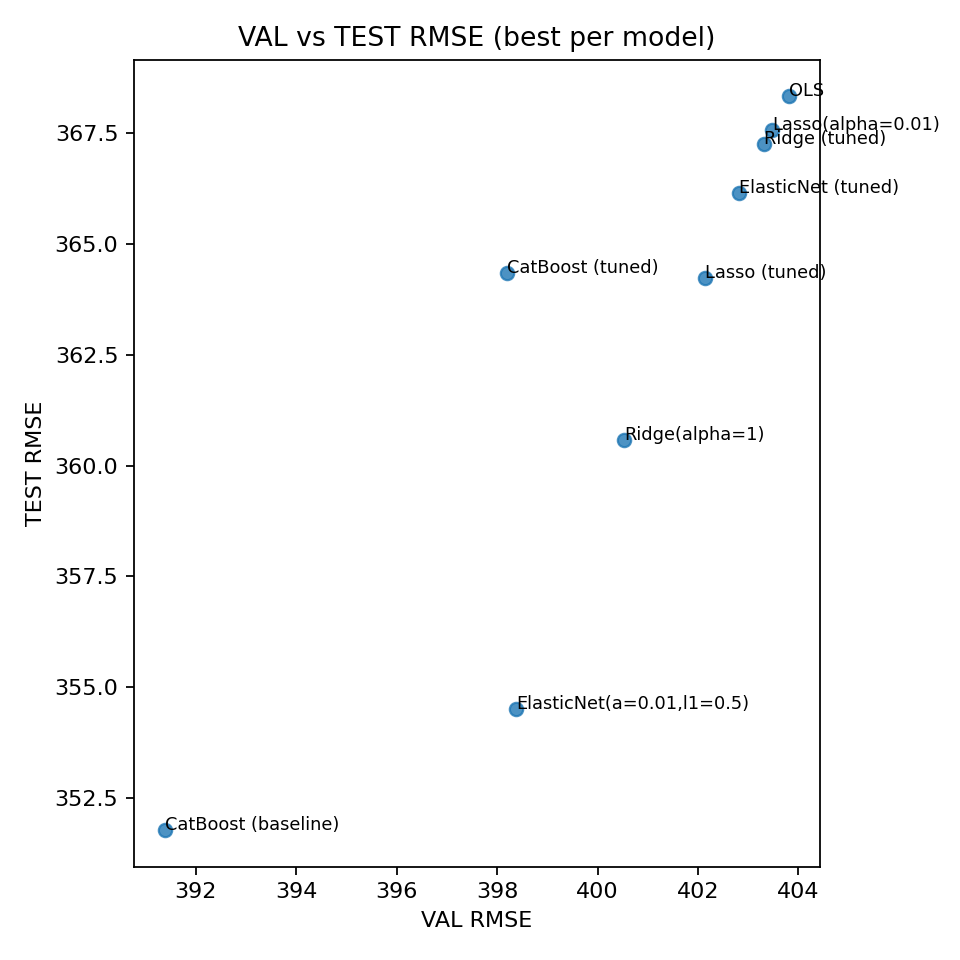

In [60]:
def show_img(name):
    p = PLOT_DIR / name
    if p.exists():
        display(Image.open(p))
    else:
        print("Missing:", p)

show_img("best_test_rmse_per_model.png")
show_img("val_vs_test_rmse_best_per_model.png")

**Zaključak poređenja:** `best_per_model.csv` daje najbolju konfiguraciju za svaki model.
Bar grafikon (TEST RMSE) pokazuje koji model najbolje generalizuje na testu, dok scatter (VAL vs TEST)
pokazuje koliko su performanse stabilne i da li postoji overfitting (veliko odstupanje između VAL i TEST).
Iako je tuning biran po CV RMSE na treningu, zbog ograničenog grida, šuma i outlier-a može se desiti da baseline bolje generalizuje na test skupu. Zbog toga prikazujemo obe varijante.

## Zaključak

Na osnovu grafika i metrika možemo zaključiti sledeće:

- **OLS (baseline)** pokazuje sistematske obrasce u rezidualima (nisu “nasumičan oblak” oko nule), kao i outliere sa velikim greškama. To ukazuje da linearni oblik ne opisuje dobro problem, a multikolinearnost dodatno može da učini OLS numerički nestabilnim.

- **Regularizovani linearni modeli (npr. Lasso tuned)** stabilizuju rešenje i generalno daju “disciplinovanije” predikcije u odnosu na OLS, ali i dalje vidimo veća odstupanja od dijagonale pri većim `y_true` vrednostima. To sugeriše da linearni modeli teže hvataju nelinearnosti, interakcije i ekstremne slučajeve (repove raspodele).

- **CatBoost** najbolje hvata kompleksnost problema: tačke su bliže dijagonali, reziduali su više centrirani oko nule i rezultati na validaciji i testu su slični, što ukazuje na dobru generalizaciju bez izraženog overfitting-a. Ipak, ekstremne vrednosti nasilnog kriminala i dalje ostaju najteže za predikciju (prisustvo outliera i “teških repova”).

Ukupno: OLS služi kao referenca i pokazuje ograničenja čistog linearnog pristupa, regularizacija popravlja stabilnost, dok CatBoost daje najbolji kompromis tačnosti i robusnosti na ovom skupu podataka.